# Intro
This is a notebook for doing evaluations for TabPFN's

You will need to run each of the following steps to initialize all the classes and functions but for the most part you can ignore these unless you want to dig in deeper.

The important note is that after running **Setup** you **must** restart your colab environment (top left, Runtime, restart runtime OR `ctrl+M .`)

The most relevant section for just running and experimenting is the **Experiment** section. You'll find any plots generated by using the _folder_ icon on the left and looking in `./plots`.

If you aren't aware `ctrl + ]` will fold all cells while `ctrl + [` will expand them all. You can also find the table of contents on the left for an easier time navigating.

**In order to get the fastest predictions you need to enable GPUs for the notebook:**
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down
(https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd)

**Note:**
The markers on the legend for the plots seems to not render, this may be due to some matplotlib version. If required, please try the most up-to-date

# Setup


In [ ]:
!git clone https://github.com/tabpfn-anonym/TabPFNForEval1Hr
!mv TabPFNForEval1Hr TabPFN
!pip install "./TabPFN"
!pip install -r TabPFN/requirements.txt
!git clone https://github.com/tabpfn-anonym/TabPFNEvaluation1Hr
!mv TabPFNEvaluation1Hr TabPFNRawResultsHourSearch
!pip install -U matplotlib adjustText # Needed for a later version where the markers for the legend work
raise Exception("restart the notebook please")

Cloning into 'TabPFNForEval1Hr'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./TabPFN
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 361 kB 33.0 MB/s 
  Created wheel for tabpfn: filename=tabpfn-0.1.7-py3-none-any.whl size=96618 sha256=f14642b8d9f66c937e33fcecfc5398f3f254963f

Cloning into 'TabPFNEvaluation1Hr'...
remote: Enumerating objects: 28141, done.
remote: Total 28141 (delta 0), reused 0 (delta 0), pack-reused 28141
Receiving objects: 100% (28141/28141), 117.40 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (21706/21706), done.
Checking out files: 100% (31983/31983), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 29.1 MB/s 
     |████████████████████████████████| 965 kB 51.2 MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7096 sha256=3aa81549ed7e056911e995874d5b5fdfeeddbaca01bfad8d155fed00ed3eee5f
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's

Exception: ignored

In [ ]:
%load_ext autoreload
%autoreload 2

# Imports

In [ ]:
from __future__ import annotations

import argparse
import pickle
import re
from tqdm import tqdm
from collections import Counter
from dataclasses import dataclass
from functools import partial
from itertools import chain, product
from pathlib import Path
from typing import Callable, Iterable, Sequence

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import adjustText  # For helping with overlapping text

import tabpfn.scripts.tabular_baselines as tb
from tabpfn.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn.scripts.tabular_baselines import clf_dict
from tabpfn.scripts.tabular_evaluation import evaluate
from tabpfn.scripts.tabular_metrics import (accuracy_metric, auc_metric,
                                            brier_score_metric,
                                            calculate_score, cross_entropy,
                                            ece_metric, time_metric)

ModuleNotFoundError: ignored

# Constants

In [ ]:
HERE = Path(".").resolve().absolute()

METRICS = {
    "roc": auc_metric,
    "cross_entropy": cross_entropy,
    "acc": accuracy_metric,
    "brier_score": brier_score_metric,
    "ece": ece_metric,
}

PREDEFINED_RESULTS_PATH = HERE / "TabPFNRawResultsHourSearch"
PREDEFINED_RESULTS_CSV_PATH = PREDEFINED_RESULTS_PATH / "predefined_results.csv"

PREDFINED_DATASET_PATHS = HERE / "TabPFN" / "tabpfn" / "datasets"
PREDEFINED_DATASET_COLLECTIONS = {
    "cc_valid": {
        "ids": open_cc_valid_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_valid_datasets_multiclass.pickle",
    },
    "cc_test": {
        "ids": open_cc_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_test_datasets_multiclass.pickle",
    },
}



LABEL_NAMES = {
    "transformer": "TabPFN",
    "transformer_gpu_N_1": "TabPFN GPU (N_ens =  1)",
    "transformer_gpu_N_4": "TabPFN GPU (N_ens =  4)",
    "transformer_gpu_N_8": "TabPFN GPU (N_ens =  8)",
    "transformer_gpu_N_32": "TabPFN GPU (N_ens = 32)",
    "transformer_cpu_N_1": "TabPFN CPU (N_ens =  1)",
    "transformer_cpu_N_4": "TabPFN CPU (N_ens =  4)",
    "transformer_cpu_N_8": "TabPFN CPU (N_ens =  8)",
    "transformer_cpu_N_32": "TabPFN CPU (N_ens = 32)",
    "autogluon": "Autogluon",
    "autosklearn2": "Autosklearn2",
    "gp_default": "default GP (RBF)",
    "gradient_boosting": "tuned Grad. Boost.",
    "gradient_boosting_default": "default Grad. Boost.",
    "lightgbm": "tuned LGBM",
    "lightgbm_default": "default LGBM",
    "gp": "tuned GP (RBF)",
    "logistic": "tuned Log. Regr.",
    "knn": "tuned KNN",
    "catboost": "tuned Catboost",
    "catboost_default": "default Catboost",
    "xgb": "tuned XGB",
    "xgb_default": "default XGB",
    "catboost_gpu": "tuned Catboost (GPU)",
    "catboost_default_gpu": "default Catboost (GPU)",
    "xgb_gpu": "tuned XGB (GPU)",
    "xgb_default_gpu": "default XGB (GPU)",
    "svm": "tuned SVM",
    "svm_default": "default SVM",
    "random_forest": "tuned Random Forest",
    "rf_default_n_estimators_10": "Rand. Forest (N_est =  10)",
    "rf_default_n_estimators_32": "Rand. Forest (N_est =  32)",
    "rf_default": "Rand. Forest (N_est = 100)",
    "autogluon": "AutoGluon",
    "autosklearn": "AutoSklearn",
    "autosklearn2": "AutoSklearn2"
}
FAMILY_NAMES = {
    "gp": "GP",
    "knn": "KNN",
    "lightgbm": "LGBM",
    "logistic": "Log. Regr.",
    "rf": "RF",
    "svm": "SVM",
    "transformer_cpu": "TabPFN CPU",
    "transformer_gpu": "TabPFN GPU",
    "xgb": "XGB CPU",
    "xgb_gpu": "XGB GPU",
    "catboost": "CatBoost CPU",
    "catboost_gpu": "CatBoost GPU",
    "autogluon": "AutoGluon",
    "autosklearn": "AutoSklearn",
    "autosklearn2": "AutoSklearn2",
    "gradient_boosting": "GB"
}

# Available Methods

In [ ]:
# Predefined methods with `no_tune={}` inidicating they are not tuned
METHODS = {
    # svm
    "svm": tb.svm_metric,
    "svm_default": partial(tb.svm_metric, no_tune={}),
    # # gradient boosting
    # "gradient_boosting": tb.gradient_boosting_metric,
    "gradient_boosting_default": partial(tb.gradient_boosting_metric, no_tune={}),
    # gp
    "gp": clf_dict["gp"],
    "gp_default": partial(
        clf_dict["gp"],
        no_tune={"params_y_scale": 0.1, "params_length_scale": 0.1},
    ),
    # autogluon
    #"autogluon": clf_dict["autogluon"],
    # autosklearn
    "autosklearn2": clf_dict["autosklearn"],
    # lightgbm
    "lightgbm": clf_dict["lightgbm"],
    "lightgbm_default": partial(clf_dict["lightgbm"], no_tune={}),
    # catboost
    #"catboost": clf_dict["catboost"],
    "catboost_default": partial(clf_dict["catboost"], no_tune={}),
    # "catboost_gpu": partial(clf_dict["catboost"], gpu_id=0),
    # "catboost_default_gpu": partial(clf_dict["catboost"], no_tune={}, gpu_id=0),
    # xgb
    "xgb": clf_dict["xgb"],
    "xgb_default": partial(clf_dict["xgb"], no_tune={}),
    "xgb_gpu": partial(clf_dict["xgb"], gpu_id=0),
    #"xgb_default_gpu": partial(clf_dict["xgb"], gpu_id=0, no_tune={}),
    # random forest
    "random_forest": clf_dict["random_forest"],
    "rf_default": partial(clf_dict["random_forest"], no_tune={}),
    "rf_default_n_estimators_10": partial(
        clf_dict["random_forest"], no_tune={"n_estimators": 10}
    ),
    "rf_default_n_estimators_32": partial(
        clf_dict["random_forest"], no_tune={"n_estimators": 32}
    ),
    # knn
    "knn": clf_dict["knn"],
    # logistic classification
    "logistic": clf_dict["logistic"],
    # Transformers
    "transformer_cpu_N_1": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=1
    ),
    "transformer_cpu_N_4": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=4
    ),
    "transformer_cpu_N_8": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=8
    ),
    "transformer_cpu_N_32": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=32
    ),
    "transformer_gpu_N_1": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=1
    ),
    "transformer_gpu_N_4": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=4
    ),
    "transformer_gpu_N_8": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=8
    ),
    "transformer_gpu_N_32": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=32
    ),
}

# Classes

### Dataset

In [ ]:
@dataclass
class Dataset:
    """Small helper class just to name entries in the loaded pickled datasets."""

    name: str
    X: torch.Tensor
    y: torch.Tensor
    categorical_columns: list[int]
    attribute_names: list[str]
    # Seems to be some things about how the dataset was constructed
    info: dict
    # Only 'multiclass' is known?
    task_type: str

    @property
    def categorical(self) -> bool:
        return len(self.categorical_columns) == len(self.attribute_names)

    @property
    def numerical(self) -> bool:
        return len(self.categorical_columns) == 0

    @property
    def mixed(self) -> bool:
        return not self.numerical and not self.categorical

    @classmethod
    def fetch(
        self,
        identifier: str | int | list[int],
        only: Callable | None = None,
    ) -> list[Dataset]:
        if isinstance(identifier, str) and identifier in PREDEFINED_DATASET_COLLECTIONS:
            datasets = Dataset.from_predefined(identifier)
        elif isinstance(identifier, int):
            identifier = [identifier]
            datasets = Dataset.from_openml(identifier)
        elif isinstance(identifier, list):
            datasets = Dataset.from_openml(identifier)
        else:
            raise ValueError(identifier)

        if only:
            return list(filter(only, datasets))
        else:
            return datasets

    @classmethod
    def from_pickle(self, path: Path, task_types: str) -> list[Dataset]:
        with path.open("rb") as f:
            raw = pickle.load(f)

        return [Dataset(*entry, task_type=task_types) for entry in raw]  # type: ignore

    @classmethod
    def from_predefined(self, name: str) -> list[Dataset]:
        assert name in PREDEFINED_DATASET_COLLECTIONS
        path = PREDEFINED_DATASET_COLLECTIONS[name]["path"]

        return Dataset.from_pickle(path, task_types="multiclass")

    @classmethod
    def from_openml(
        self,
        dataset_id: int | list[int],
        filter_for_nan: bool = False,
        min_samples: int = 100,
        max_samples: int = 2_000,
        num_feats: int = 100,
        return_capped: bool = False,
        shuffled: bool = True,
        multiclass: bool = True,
    ) -> list[Dataset]:
        # TODO: should be parametrized, defaults taken from ipy notebook
        if not isinstance(dataset_id, list):
            dataset_id = [dataset_id]

        datasets, _ = load_openml_list(
            dataset_id,
            filter_for_nan=filter_for_nan,
            num_feats=num_feats,
            min_samples=min_samples,
            max_samples=max_samples,
            return_capped=return_capped,
            shuffled=shuffled,
            multiclass=multiclass,
        )
        return [
            Dataset(  # type: ignore
                *entry,
                task_type="multiclass" if multiclass else "binary",
            )
            for entry in datasets
        ]

    def as_list(self) -> list:
        """How the internals expect a dataset to look like."""
        return [
            self.name,
            self.X,
            self.y,
            self.categorical_columns,
            self.attribute_names,
            self.info,
        ]

### Results

In [ ]:
@dataclass
class Results:
    # Big ass predefined dictionary
    df: pd.DataFrame

    @classmethod
    def from_dict(
        self,
        d: dict,
        datasets: list[Dataset],
        recorded_metrics: list[str],
        *,
        dropna: bool = True,
    ) -> Results:
        # TODO: we could extract dataset_names for the dict but it's not ordered well
        #   for that. Likewise for the recorded_metrics
        #
        # We do a lot of parsing here to massage things into a nice table
        # Extract all the times listed in the keys
        pattern = re.compile(
            r"(?P<method>\w+)"
            r"_time_(?P<time>\d+(\.\d+)?)"
            r"(_)?(?P<metric>\w+)"
            r"_split_(?P<split>\d+)"
        )

        groups = []
        for key in d:
            match = re.match(pattern, key)
            if not match:
                raise ValueError(key)

            groups.append(match.groupdict())

        matches = pd.DataFrame(groups)

        # The unique, methods, times, metrics and splits present
        methods = list(matches["method"].unique())
        times = list(matches["time"].astype(float).unique())
        metrics = list(matches["metric"].unique())
        splits = list(matches["split"].astype(int).unique())

        # Next we extract all the eval_positions
        _eval_positions = set()
        for v in d.values():
            _eval_positions.update(v["eval_positions"])
        eval_positions = sorted(_eval_positions)

        # Dataset names...
        dataset_names = sorted([d.name for d in datasets])

        # We flatten out the fit_time and inference_time of best_config
        for (k, v), pos, dataset in product(d.items(), eval_positions, datasets):
            old_best_configs_key = f"{dataset.name}_best_configs_at_{pos}"

            best_config_key = f"{dataset.name}_best_config"
            inference_time_key = f"{dataset.name}_inference_time_at_{pos}"
            fit_time_key = f"{dataset.name}_fit_time_at_{pos}"

            # If there is a best config
            if "transformer_gpu" not in k and "autosklearn" not in k and any(v.get(old_best_configs_key, [])):
                assert len(v[old_best_configs_key]) == 1

                best_config = v[old_best_configs_key][0]

                v[inference_time_key] = best_config.get("inference_time", np.nan)
                v[fit_time_key] = best_config.get("fit_time", np.nan)
                v[best_config_key] = best_config.copy()
                del v[old_best_configs_key]
            else:
                v[inference_time_key] = np.nan
                v[fit_time_key] = np.nan
                v[best_config_key] = np.nan

        index = pd.MultiIndex.from_product(
            [methods, metrics, times, eval_positions, splits],
            names=[
                "method",
                "optimization_metric",
                "optimization_time",
                "eval_position",
                "split",
            ],
        )

        metrics = recorded_metrics + ["inference_time", "fit_time"]
        if "time" not in metrics:
            metrics.append("time")

        columns = pd.MultiIndex.from_product(
            [metrics, dataset_names],
            names=["metric", "dataset"],
        )

        df = pd.DataFrame(columns=columns, index=index)
        df.sort_index(inplace=True)

        for k, v in d.items():
            match = re.match(pattern, k)
            if match is None:
                raise ValueError(k)

            method = match.group("method")
            time = float(match.group("time"))
            opt_metric = match.group("metric")
            split = int(match.group("split"))

            for dataset, metric, pos in product(dataset_names, metrics, eval_positions):
                row = (method, opt_metric, time, int(pos), split)
                col = (metric, dataset)

                value = v.get(f"{dataset}_{metric}_at_{pos}", np.nan)

                df.loc[row, col] = value

        # Drop full NaN rows
        if dropna:
            df = df[df.any(axis=1)]

        return Results(df)

    def at(
        self,
        *,
        method: str | list[str] | None = None,
        optimization_metric: str | list[str] | None = None,
        optimization_time: float | list[float] | None = None,
        split: int | list[int] | None = None,
        eval_position: int | list[int] | None = None,
        dataset: str | list[str] | None = None,
        metric: str | list[str] | None = None,
    ) -> Results:
        """Use this for slicing in to the dataframe to get what you need"""
        df = self.df
        items = {
            "method": method,
            "optimization_time": optimization_time,
            "optimization_metric": optimization_metric,
            "split": split,
            "eval_position": eval_position,
        }
        for name, item in items.items():
            if item is None:
                continue
            idx: list = item if isinstance(item, list) else [item]
            df = df[df.index.get_level_values(name).isin(idx)]
            if not isinstance(item, list):
                df = df.droplevel(name, axis="index")

        if dataset:
            _dataset = dataset if isinstance(dataset, list) else [dataset]
            df = df.T.loc[df.T.index.get_level_values("dataset").isin(_dataset)].T
            if not isinstance(dataset, list):
                df = df.droplevel("dataset", axis="columns")

        if metric:
            _metric = metric if isinstance(metric, list) else [metric]
            df = df.T.loc[df.T.index.get_level_values("metric").isin(_metric)].T
            if not isinstance(metric, list):
                df = df.droplevel("metric", axis="columns")

        return Results(df)

    @property
    def methods(self) -> list[str]:
        return list(self.df.index.get_level_values("method").unique())

    @property
    def optimization_metrics(self) -> list[str]:
        return list(self.df.index.get_level_values("optimization_metric").unique())

    @property
    def optimization_times(self) -> list[float]:
        return list(self.df.index.get_level_values("optimization_time").unique())

    @property
    def eval_positions(self) -> list[int]:
        return list(self.df.index.get_level_values("eval_position").unique())

    @property
    def datasets(self) -> list[str]:
        return list(self.df.columns.get_level_values("dataset").unique())

    @property
    def metrics(self) -> list[str]:
        return list(self.df.columns.get_level_values("metric").unique())

### Plotter

In [ ]:
@dataclass
class Plotter:
    result: Results

    def overall_plot(
        self,
        *,
        # Subset to plot
        eval_position: int = 1_000,
        optimization_time: float = 30.0,
        optimization_metric: str = "roc_auc",
        metric: str = "acc",
        # Ticks
        hlines: Sequence[str] | None = None, #("transformer_cpu_N_32",),
        vlines: bool = True,
        # What to plot
        stat_kind: str = "mean", # mean, median
        x_variance: bool = False,
        y_variance: bool = True,
        # Extra
        legend: str = "box",  # box, text
        xgridlines: str | None = "major",  # major, minor, both, None
        ygridlines: str | None = "both", # major, minor, both, None
        ax: plt.Axes,
    ) -> plt.Axes:
        # Hardcoded just to go with styling things below
        quantile_pairs = [(0.05, 0.95), (0.25, 0.75)]
        quantile_mark = [(0.05, 0.95), (0.25, 0.75)]
        quantiles = sorted(set(chain.from_iterable(quantile_pairs)))

        # Used when performing aggregations
        def quantile_agg(n):
            def quantile_(_x):
                return _x.quantile(n)
            quantile_.__name__ = 'q_{:2.0f}'.format(n*100)
            return quantile_

        quantile_fs = [quantile_agg(q) for q in quantiles]

        s_point = 100
        alpha_point = 0.1
        family_join_alpha = 0.8
        family_join_linewidth = 0.25
        family_join_linestyle="--"

        std_alpha = 0.5
        std_linewidth = 3
        q_alpha = {
            0: 0.2,
            0.05: 0.3,
            0.25: 0.5
        }
        q_linewidth = {
            0: 1,
            0.05: 2,
            0.25: 3
        }

        r = self.result.at(
            optimization_metric=optimization_metric,
            optimization_time=optimization_time,
            eval_position=eval_position,
            metric=[metric, "time"],
        )

        # metric        acc       time
        # method split
        # gp     0      0.786164  39.354000
        #        1      0.786164  38.317375
        # ...           ...        ...
        # xgb    19     0.794751   0.148113
        #        20     0.794751   0.148113
        df = r.df.groupby(["method", "split"]).mean().T.groupby("metric").mean().T

        # For dataset cross dataset aggregation
        # df = r.df.unstack(level="method").mean().unstack("metric").reset_index()

        #        | acc                                         time
        #        | mean std median q0.05, q0.25, q0.75, q0.95  mean std median q0.05, q0.25, q0.75, q0.95
        # method |
        # gp     |
        # ...    |
        # xgb    |
        table = df.groupby("method").agg({
            metric: ["mean", "std", "median", *quantile_fs],
            "time": ["mean", "std", "median", *quantile_fs],
        })

        methods = table.index
        families = set(map(Plotter.family, methods))

        palette = {
            h: c for h, c
            in zip(families, sns.color_palette(n_colors=len(families)))
        }

        markers = self.markers(sorted(methods, key=lambda method: LABEL_NAMES[method]))
        colors = {method: palette[Plotter.family(method)] for method in methods}

        # Draw the center point, whether it be mean or median
        for method, group in table.groupby("method"):

            sns.scatterplot(
                data=group,
                x=("time", stat_kind),
                y=(metric, stat_kind),
                ax=ax,
                s=s_point,
                color=colors[method],
                marker=markers[method],
            )

            if stat_kind == "mean":
                x = group[("time", "mean")]
                y = group[(metric, "mean")]

                # Variance lines
                if x_variance:
                    x_std = group[("time", "std")]
                    ax.plot(
                        [x - x_std, x + x_std],
                        [y, y],
                        color=colors[method],
                        alpha=std_alpha,
                        linewidth=std_linewidth,
                        marker="|",
                    )
                if y_variance:
                    y_std = group[(metric, "std")]
                    ax.plot(
                        [x, x],
                        [y - y_std, y + y_std],
                        color=colors[method],
                        alpha=std_alpha,
                        linewidth=std_linewidth,
                        marker="_",
                    )

            # If using median, use quantiles and Quantiles
            elif stat_kind == "median":
                x = group[("time", "median")]
                y = group[(metric, "median")]
                for (q_low, q_high) in quantile_pairs:
                    if x_variance:
                        x_low = group[("time", f"q{q_low}")]
                        x_high = group[("time", f"q{q_low}")]
                        ax.plot(
                            [x_low, x_high],
                            [y, y],
                            color=colors[method],
                            alpha=q_alpha[q_low],
                            linewidth=q_linewidth[q_low],
                            marker="|",
                        )

                    if y_variance:
                        y_low = group[(metric, f"q{q_low}")]
                        y_high = group[(metric, f"q{q_low}")]
                        ax.plot(
                            [x, x],
                            [y_low, y_high],
                            color=colors[method],
                            alpha=q_alpha[q_low],
                            linewidth=q_linewidth[q_low],
                            marker="_"
                            )
            else:
                raise NotImplementedError(stat_kind)

        # Families
        texts = []
        for family, group in table.groupby(Plotter.family):
            # Sort by the time axis
            xs, ys = zip(*sorted(zip(
                group[("time", stat_kind)], group[(metric, stat_kind)]
            )))

            # Line between family points
            ax.plot(
                xs,
                ys,
                color=palette[family],
                linestyle=family_join_linestyle,
                alpha=family_join_alpha,
                linewidth=family_join_linewidth,
            )

            # Text at the left most instance
            leftmost = 0
            mid_x, mid_y = xs[leftmost], ys[leftmost]
            t = ax.text(
                mid_x,
                mid_y,
                FAMILY_NAMES[family],
                color=palette[family],
                fontweight="bold",
                path_effects=[pe.withStroke(linewidth=1, foreground="black")]
            )
            texts.append(t)

        ax.set_xscale("log")  # This log scaling needs to happen before adjust_text

        # adjust_text will make sure labels don;t overlap, the xs and ys are points to not cover if it can
        adjustText.adjust_text(
            texts,
            x=list(table[("time", stat_kind)]),
            y=list(table[(metric, stat_kind)]),
            expand_points=(1.1, 1.3), # default (1.05, 1.2)
        )

        # We unfortunatly have to create a manual legend just due to seaborn not being
        # very flexible in that respect
        family_methods = sorted([(self.family(m), m) for m in set(methods)])

        items = [
            (
                family,
                LABEL_NAMES[method],
                Line2D(
                    [],
                    [],
                    color=colors[method],
                    marker=markers[method],
                    linestyle="",
                ),
            )
            for family, method in family_methods
        ]
        # Sort just by family and label
        _, labels, handles = zip(*sorted(items, key=lambda x: x[:2]))

        # create a legend only using the items
        ax.legend(
            handles,
            labels,
            title="Method",
            fontsize=10,
            facecolor="white",
        )

        # Labels
        ax.set_xlabel("Time spent for optimize/fit + predict (s)", fontweight="bold", fontsize="large")
        ax.set_ylabel(metric, fontweight="bold", fontsize="large")

        # Ticks
        ax.tick_params(axis='both', which='major', labelsize="large")

        # X-ticks
        xticks = {0.01: "0.01s", 0.1: "0.1s", 1: "1s", 10: "10s", 100: "100s", 1_000: "1000s", 60*60: "1hr"}
        ax.tick_params(axis="x", which="minor")
        ax.set_xticks(list(xticks.keys()))
        ax.set_xticklabels(list(xticks.values()))

        # Vertical lines at the times
        if vlines:
            for tick in xticks.keys():
                ax.axvline(tick, ymin=0, ymax=1, linestyle="--", alpha=0.1, linewidth=0.5)

        # Horizontal method at given methods
        if hlines:
            # For some reason we now have to re-round them
            yticks_labels = dict(zip(ax.get_yticks(), ax.get_yticklabels()))
            for method in hlines:
                y_value = table.loc[method][(metric, stat_kind)]
                ax.axhline(y_value, linestyle="--", alpha=0.1, linewidth=0.5)
                yticks_labels[y_value] = f"{y_value:.3f}"

            ax.set_yticks(list(yticks_labels.keys()))
            ax.set_yticklabels(list(yticks_labels.values()))

        return ax

    @classmethod
    def family(cls, method: str) -> str:
        for f in FAMILY_NAMES:
            if method.startswith(f):
                return f

        # Exceptions
        if "random_forest" in method:
            return "rf"

        return method

    @classmethod
    def markers(cls, methods: Iterable[str]) -> dict[str, str]:
        markers = ["o", "v", "s", "D", "8", "X", "*"]
        styles: dict[str, str] = {}

        counter: Counter[str] = Counter()
        for method in methods:
            family = cls.family(method)
            idx = counter[family]
            styles[method] = markers[idx]
            counter[family] += 1

        return styles


# Functions

In [ ]:
def eval_method(
    datasets: list[Dataset],
    label: str,
    classifier_evaluator: Callable,
    max_time: float | None,
    metric_used: Callable,
    split: int,
    eval_positions: list[int],
    result_path: Path,
    append_metric: bool = True,
    fetch_only: bool = False,
    verbose: bool = False,
    bptt: int = 2000,
    overwrite: bool = False,
):
    """Evaluate a given method."""
    if max_time is not None:
        label += f"_time_{max_time}"

    if append_metric:
        label += f"_{tb.get_scoring_string(metric_used, usage='')}"

    if isinstance(classifier_evaluator, partial):
        device = classifier_evaluator.keywords.get("device", "cpu")
    else:
        device = "cpu"

    task_type = "multiclass"
    if any(d.task_type != task_type for d in datasets):
        raise RuntimeError("Not sure how to handle this yet")

    return evaluate(
        datasets=[d.as_list() for d in datasets],
        model=classifier_evaluator,
        method=label,
        bptt=bptt,
        base_path=result_path,
        eval_positions=eval_positions,
        device=device,
        max_splits=1,
        overwrite=overwrite,
        save=True,
        metric_used=metric_used,
        path_interfix=task_type,
        fetch_only=fetch_only,
        split_id=split,
        verbose=verbose,
        max_time=max_time,
    )

def do_evaluations(args: argparse.Namespace, datasets: list[Dataset]) -> Results:
    results = {}
    for method, metric, time, split in product(
        args.methods,
        args.optimization_metrics,
        args.times,
        range(1, args.splits+1),
    ):
        metric_f = METRICS[metric]
        metric_name = tb.get_scoring_string(metric_f, usage="")
        key = f"{method}_time_{time}{metric_name}_split_{split}"

        results[key] = eval_method(
            datasets=datasets,
            label=method,
            result_path=args.result_path,
            classifier_evaluator=METHODS[method],
            eval_positions=args.eval_positions,  # It's a constant basically
            fetch_only=args.fetch_only,
            verbose=args.verbose,
            max_time=time,
            metric_used=metric_f,
            split=split,
            overwrite=args.overwrite,
        )

    datasets_as_list = [d.as_list() for d in datasets]

    # This will update the results in place
    for metric in args.recorded_metrics:
        metric_f = METRICS[metric]
        calculate_score(
            metric=metric_f,
            name=metric,
            global_results=results,
            ds=datasets_as_list,
            eval_positions=args.eval_positions,
        )

    # We also get the times
    calculate_score(
        metric=time_metric,
        name="time",
        global_results=results,
        ds=datasets_as_list,
        eval_positions=args.eval_positions,
    )

    return Results.from_dict(
        results,
        datasets=datasets,
        recorded_metrics=args.recorded_metrics + ["time"],
    )

def do_plot(
    result: Results,
    title_prefix: str,
    fig_name: str,
    path: Path,
    figsize: tuple[int, int] = (12, 10),
    dpi: int = 120,
    extension: str = "png",
    eval_position: int = 1_000,
    shift_legend: bool = True,
) -> None:
    for metric, opt_time, opt_metric in zip(
        [m for m in result.metrics if "time" not in m],
        result.optimization_times,
        result.optimization_metrics,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        Plotter(result).overall_plot(
            optimization_metric=opt_metric,
            optimization_time=opt_time,
            eval_position=eval_position,
            metric=metric,
            ax=axes,
        )
        axes.set_title(f"{title_prefix} [opt_time={opt_time}, opt_metric={opt_metric}]")

        if shift_legend:
            sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

        stem = f"{fig_name}_opt_metric_{opt_metric}_opt_time_{opt_time}_metric_{metric}"
        fig.savefig(path / f"{stem}.{extension}", bbox_inches="tight")
        # plt.close()

import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


<a name="experiment"></a>
# Experiment

Dataset Collections: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


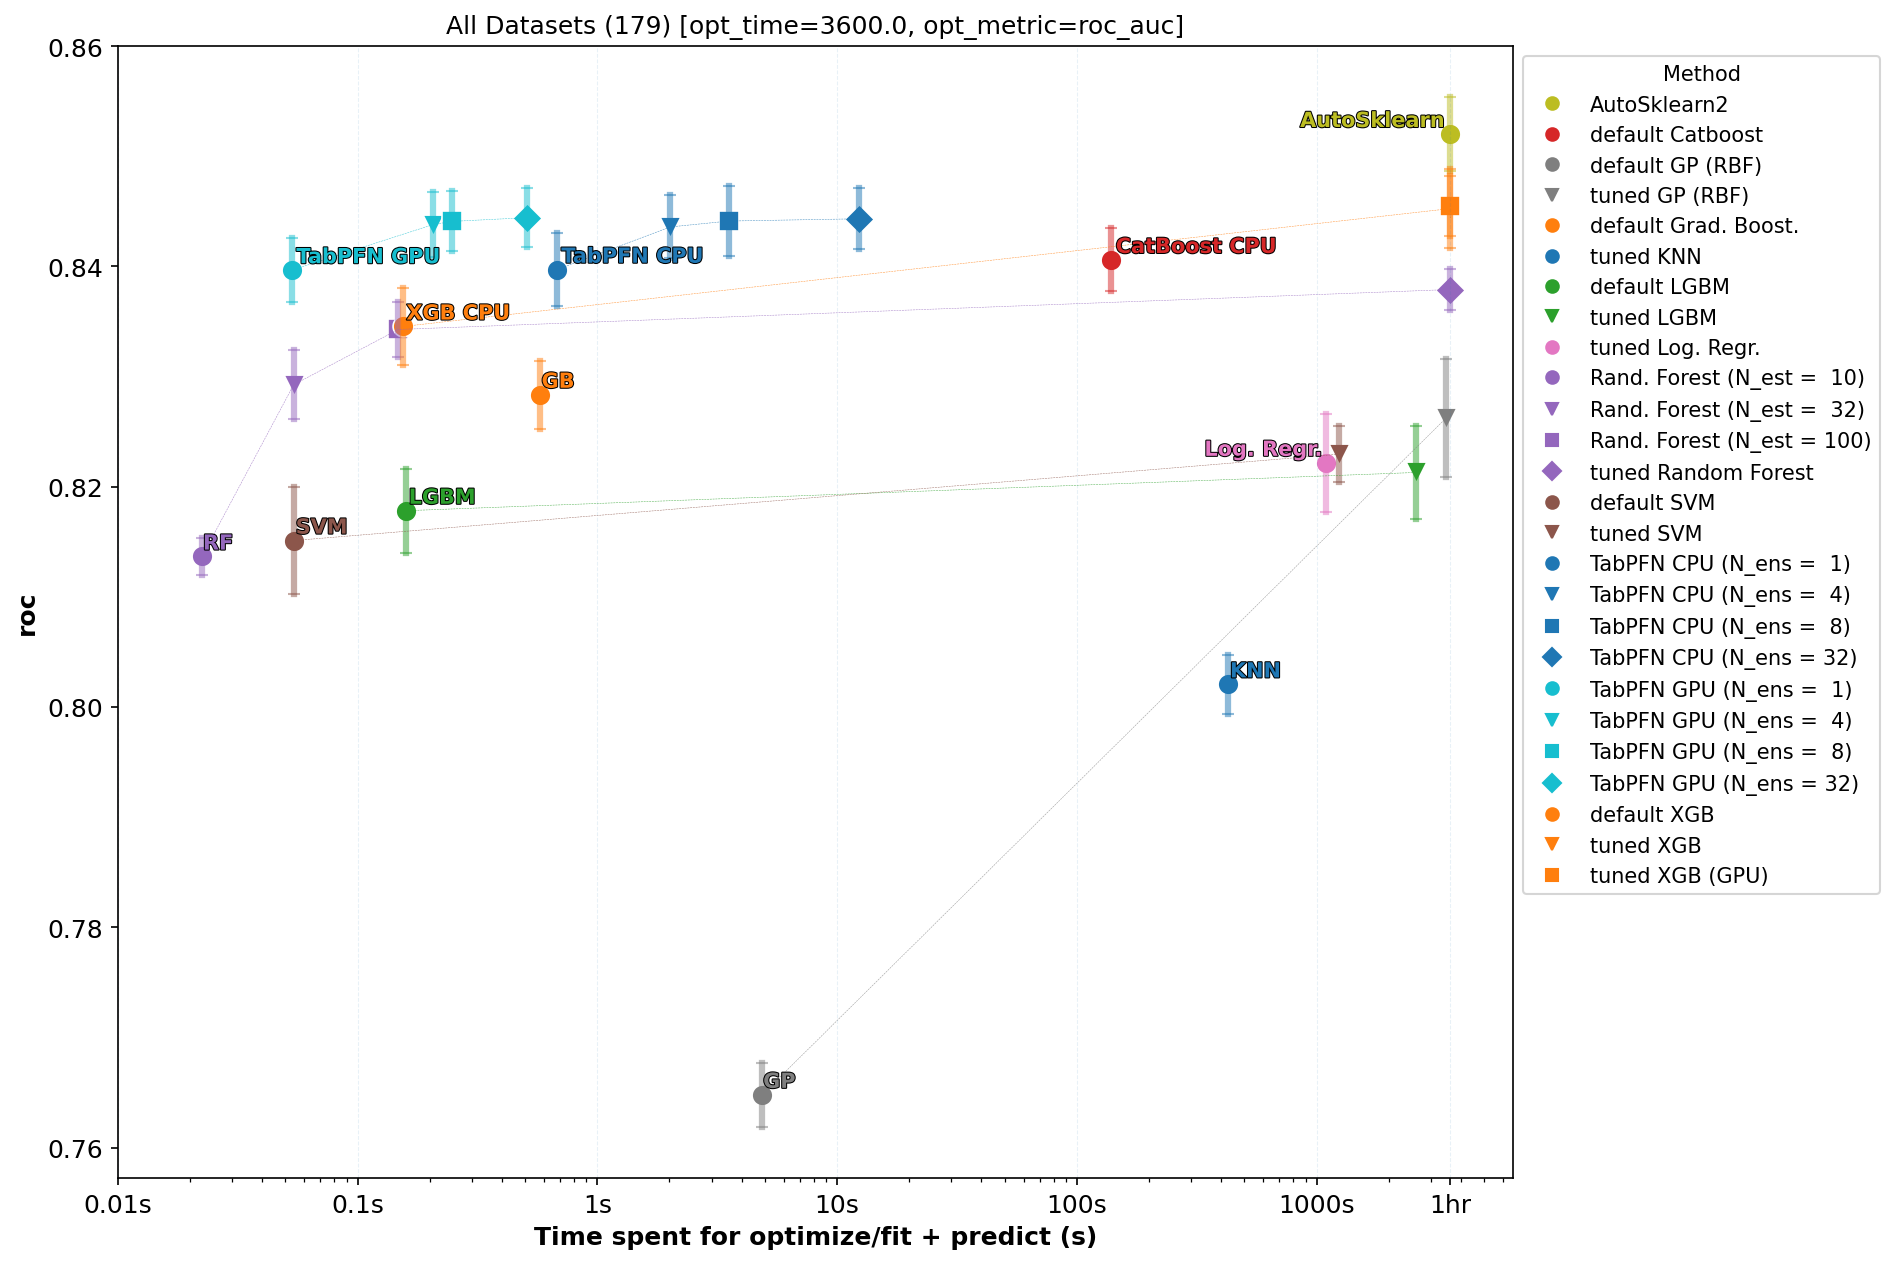

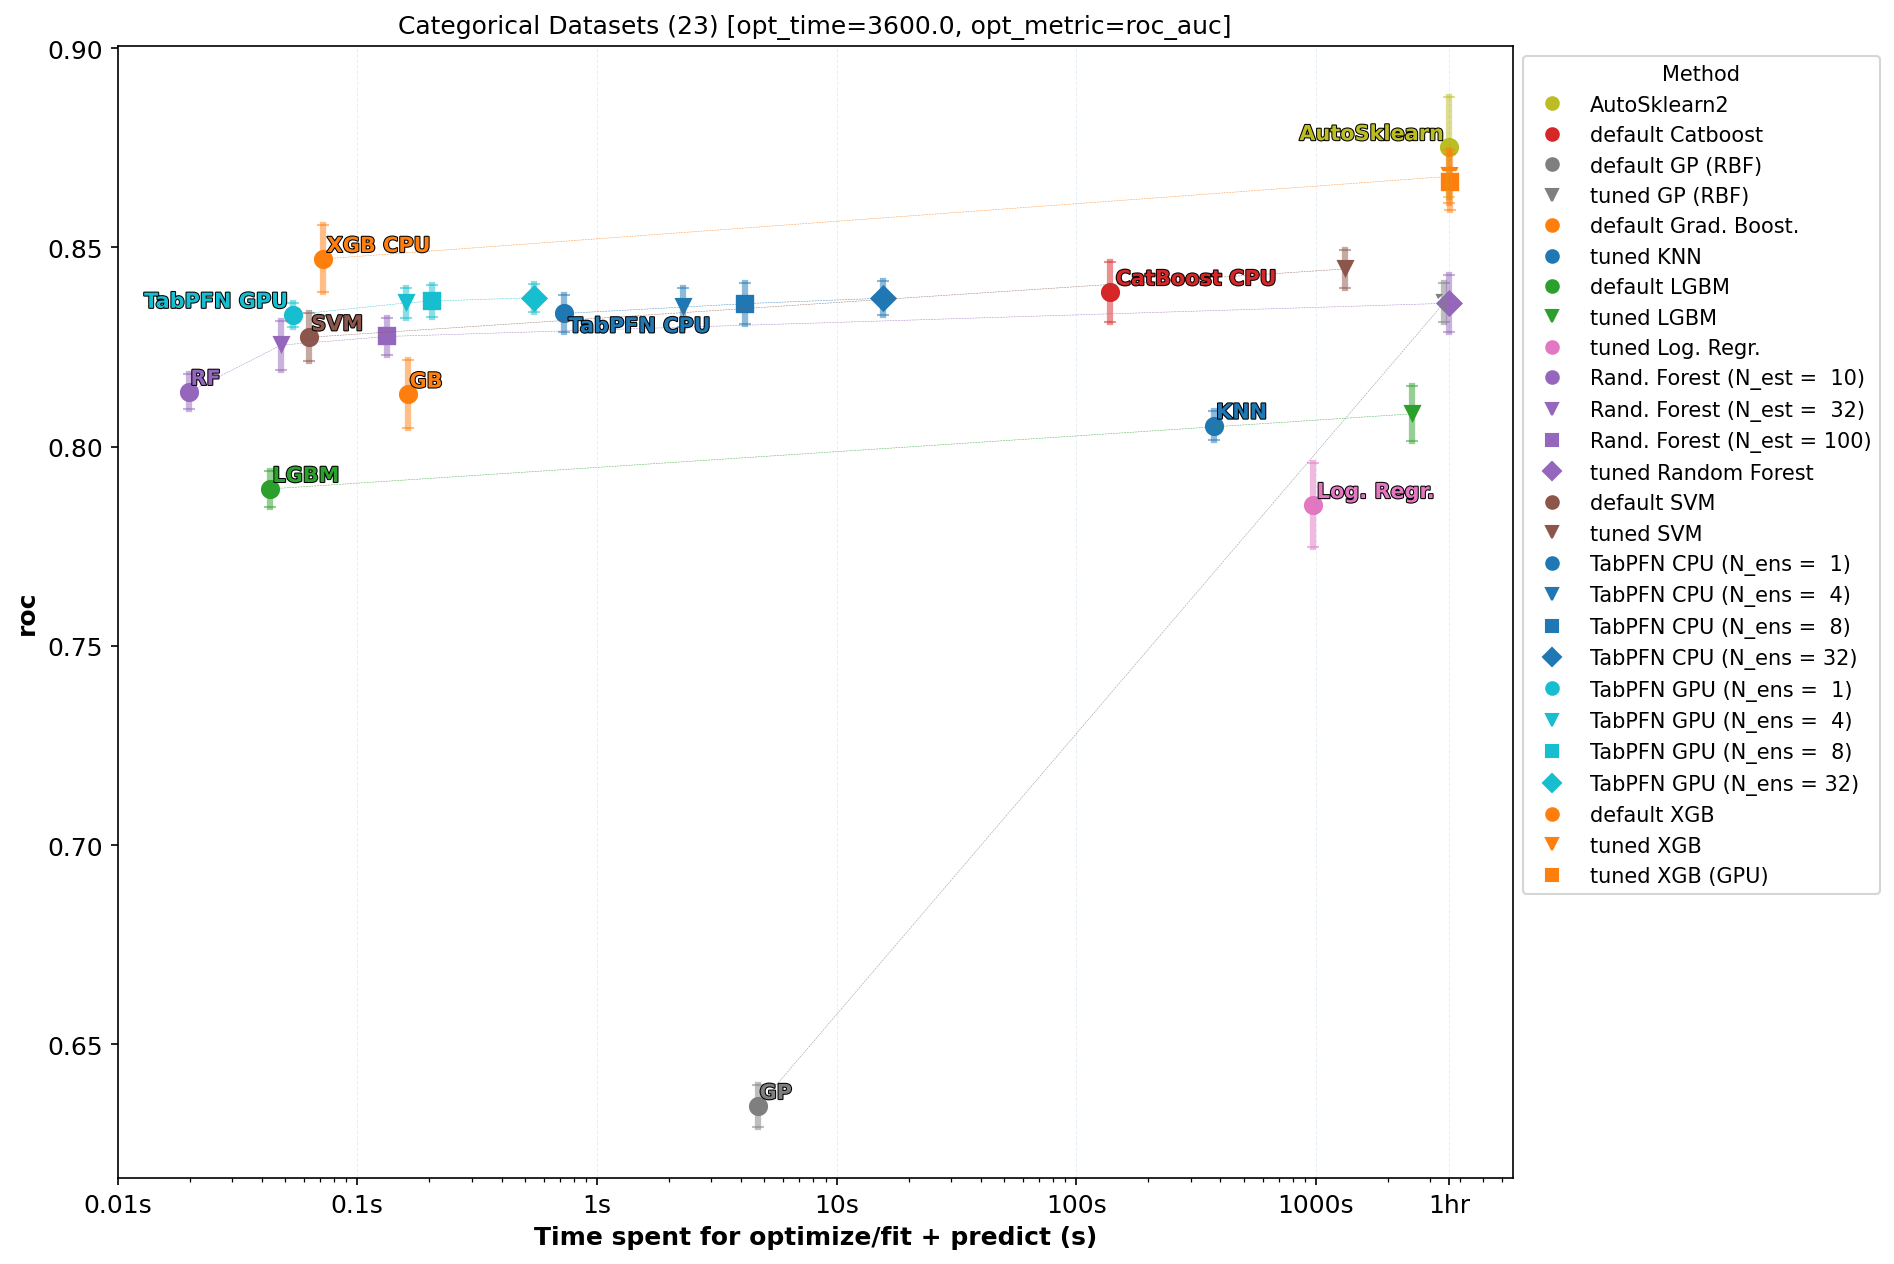

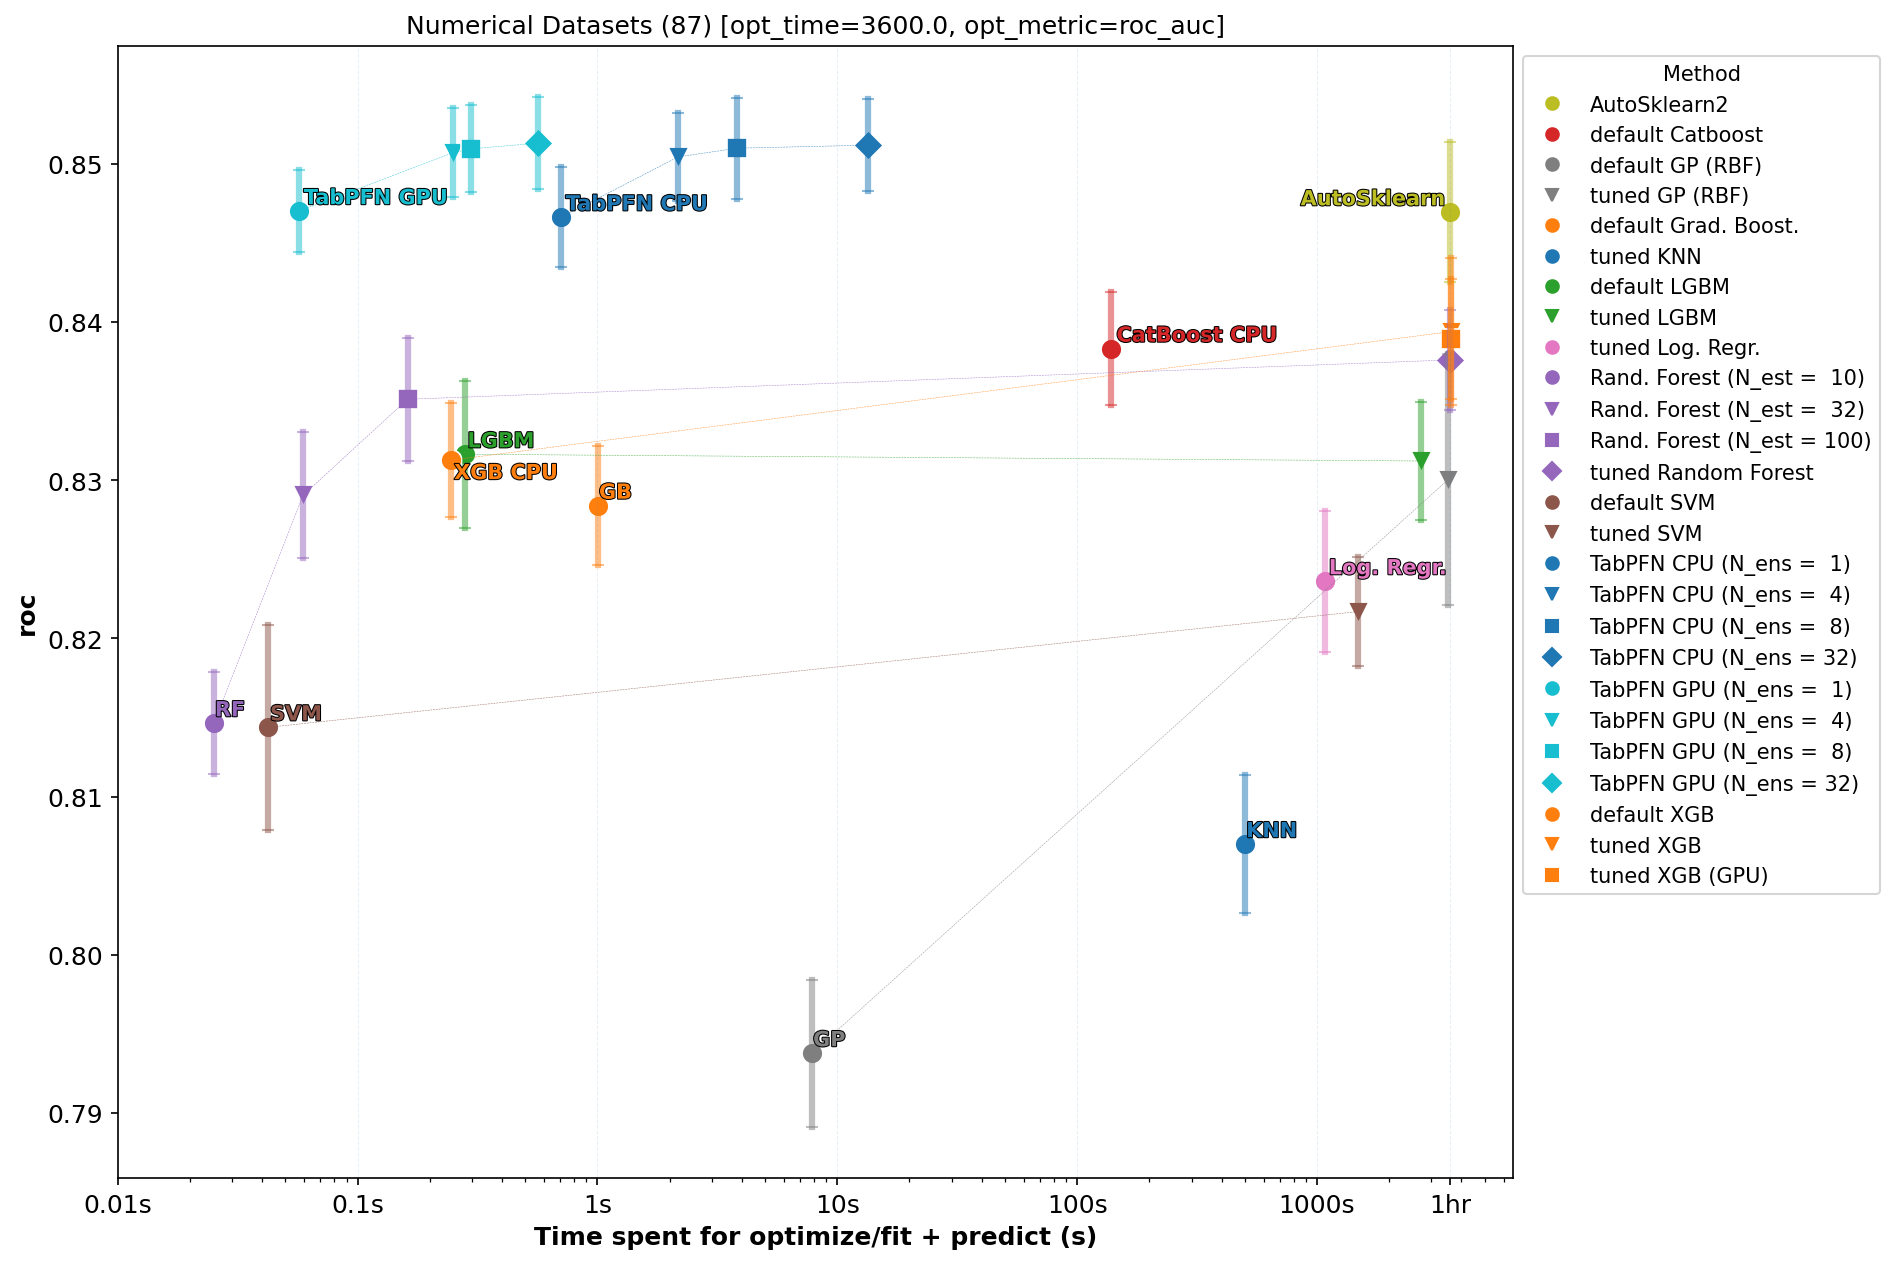

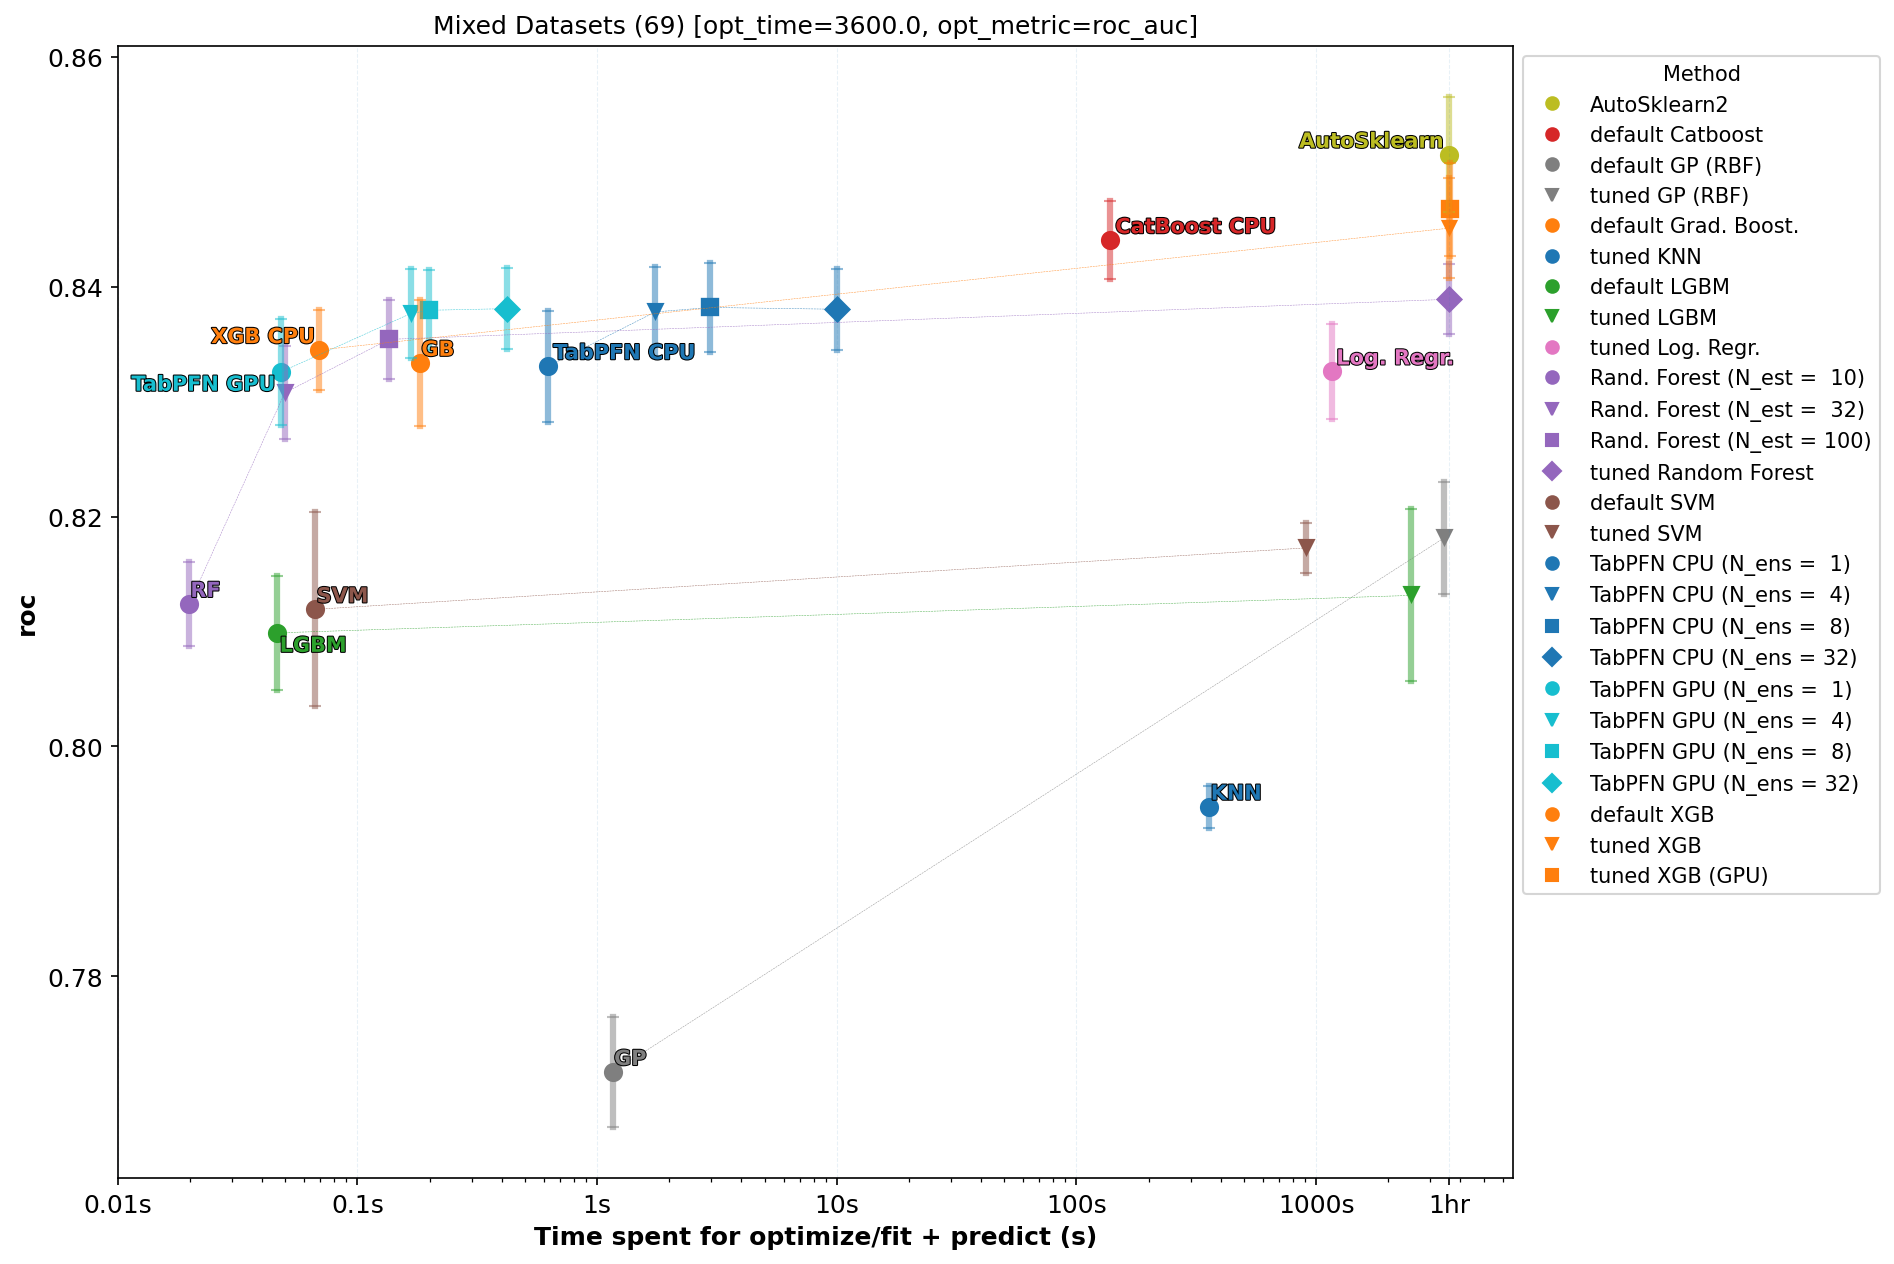

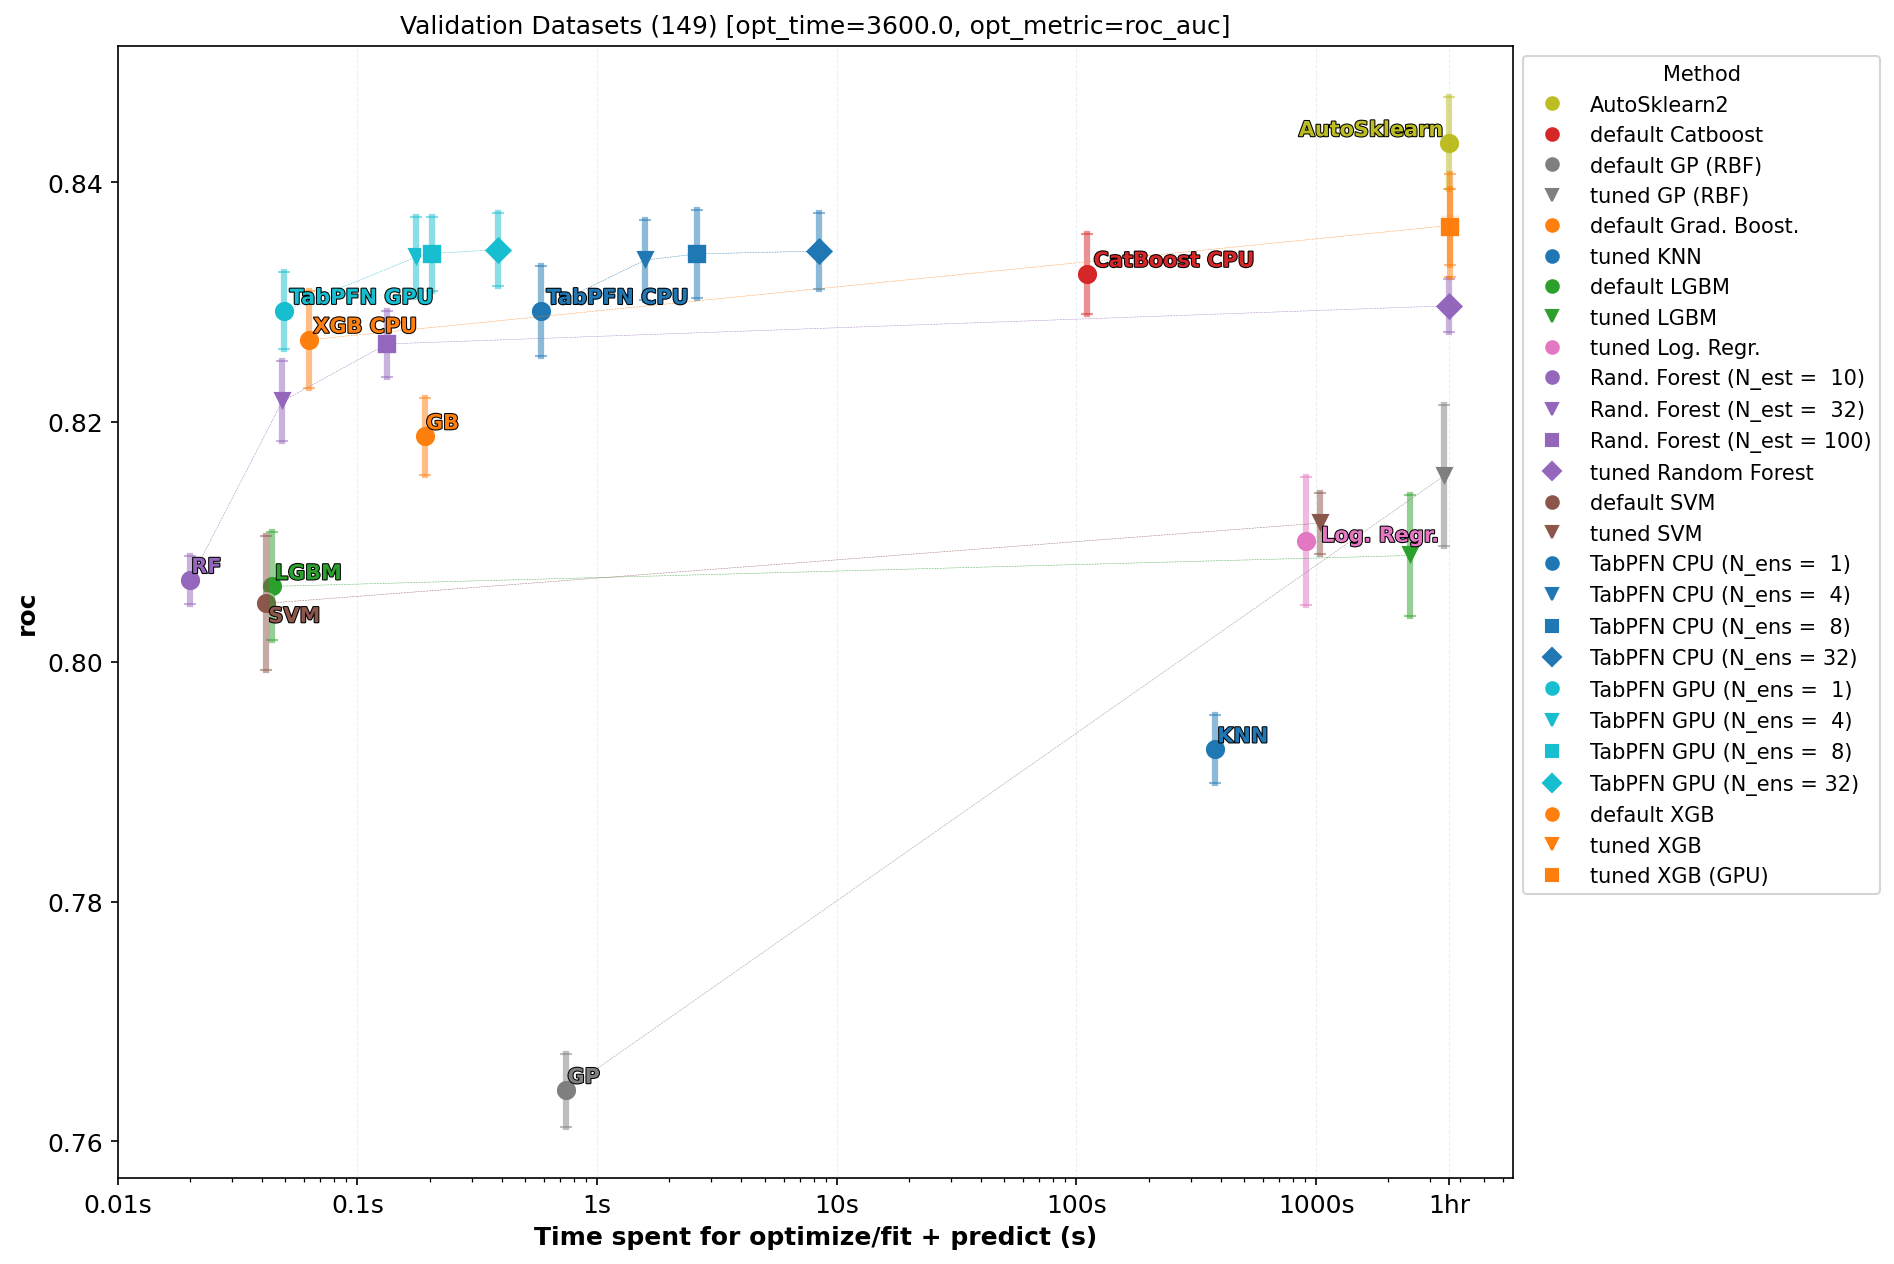

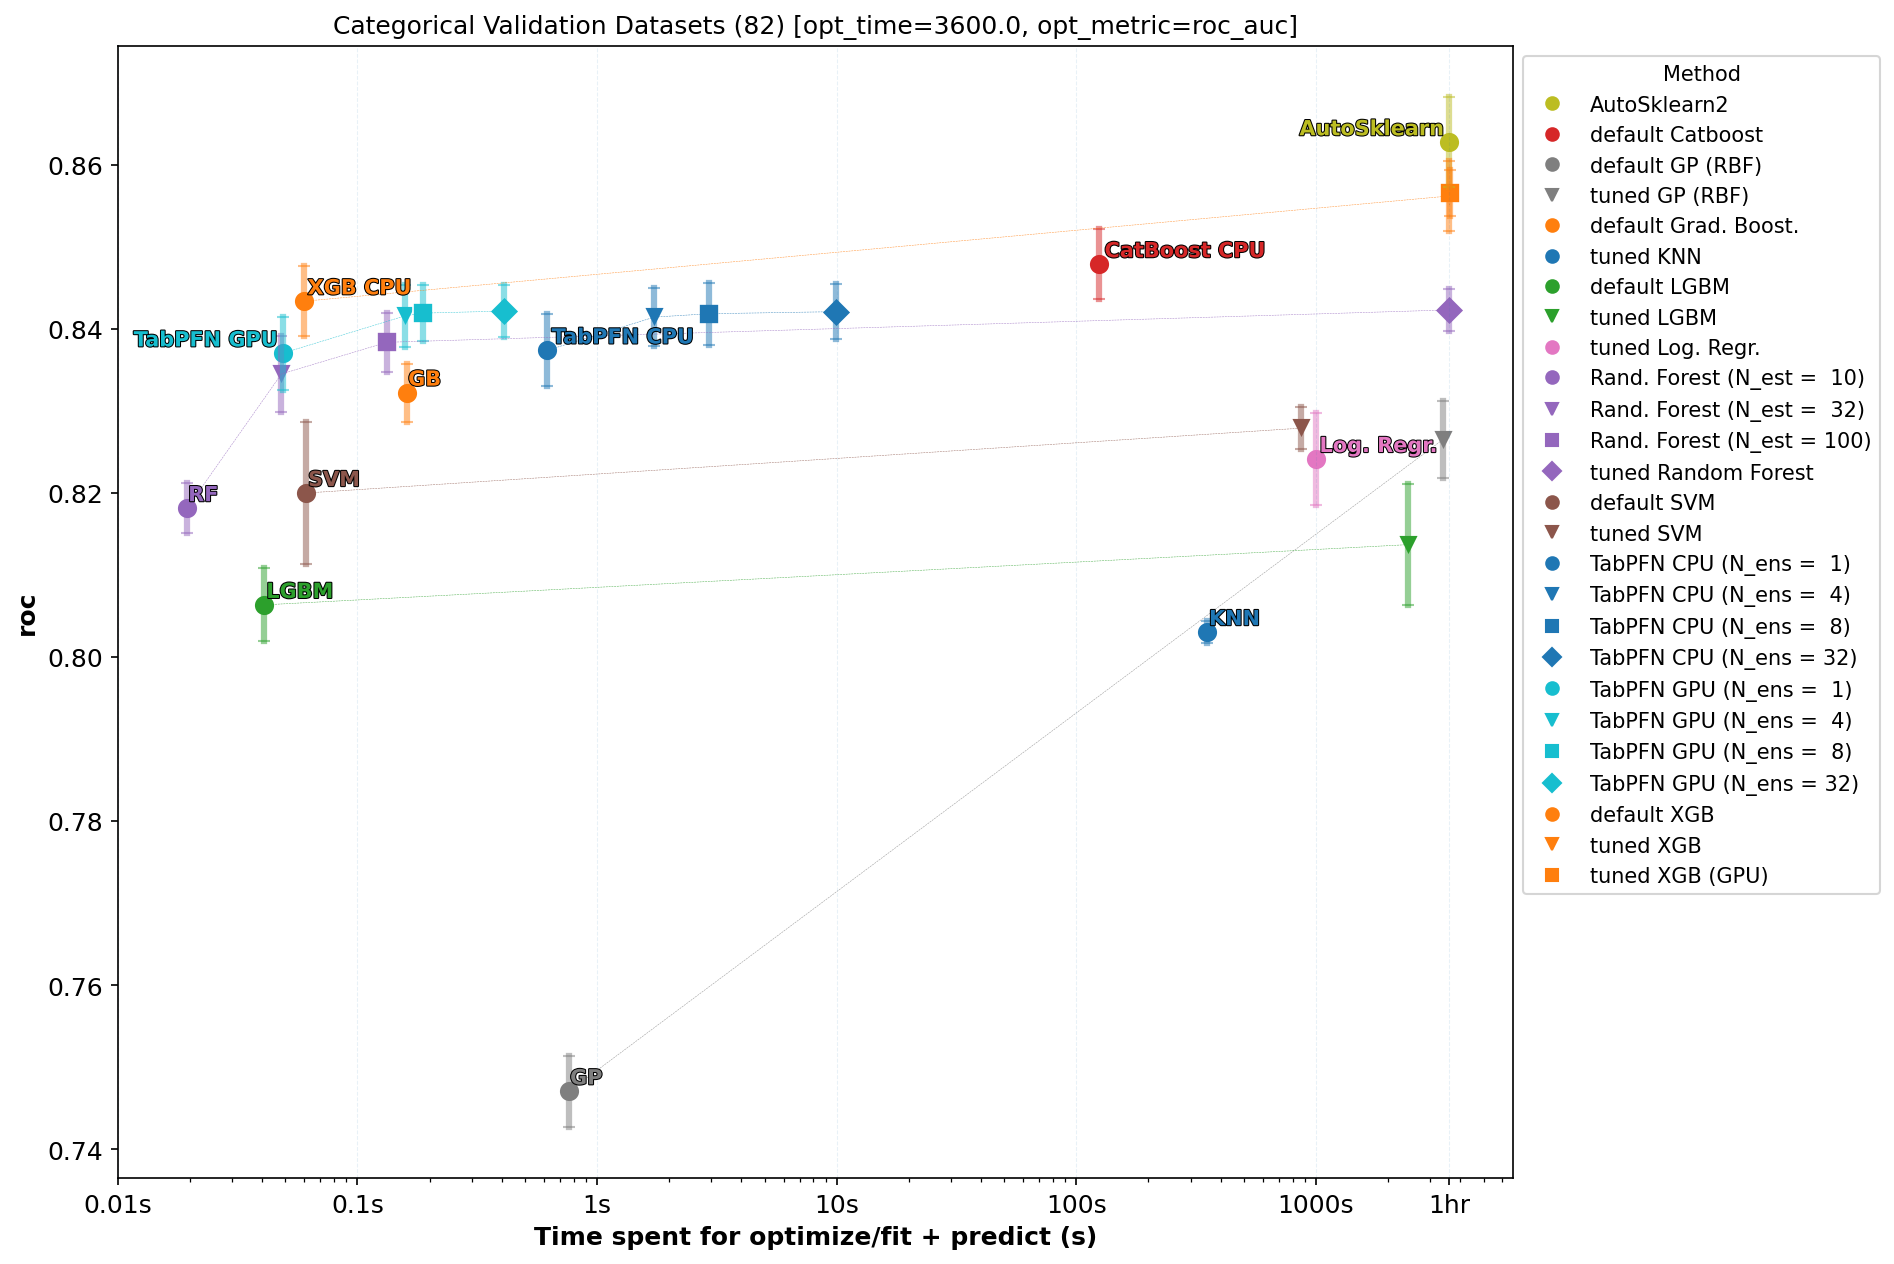

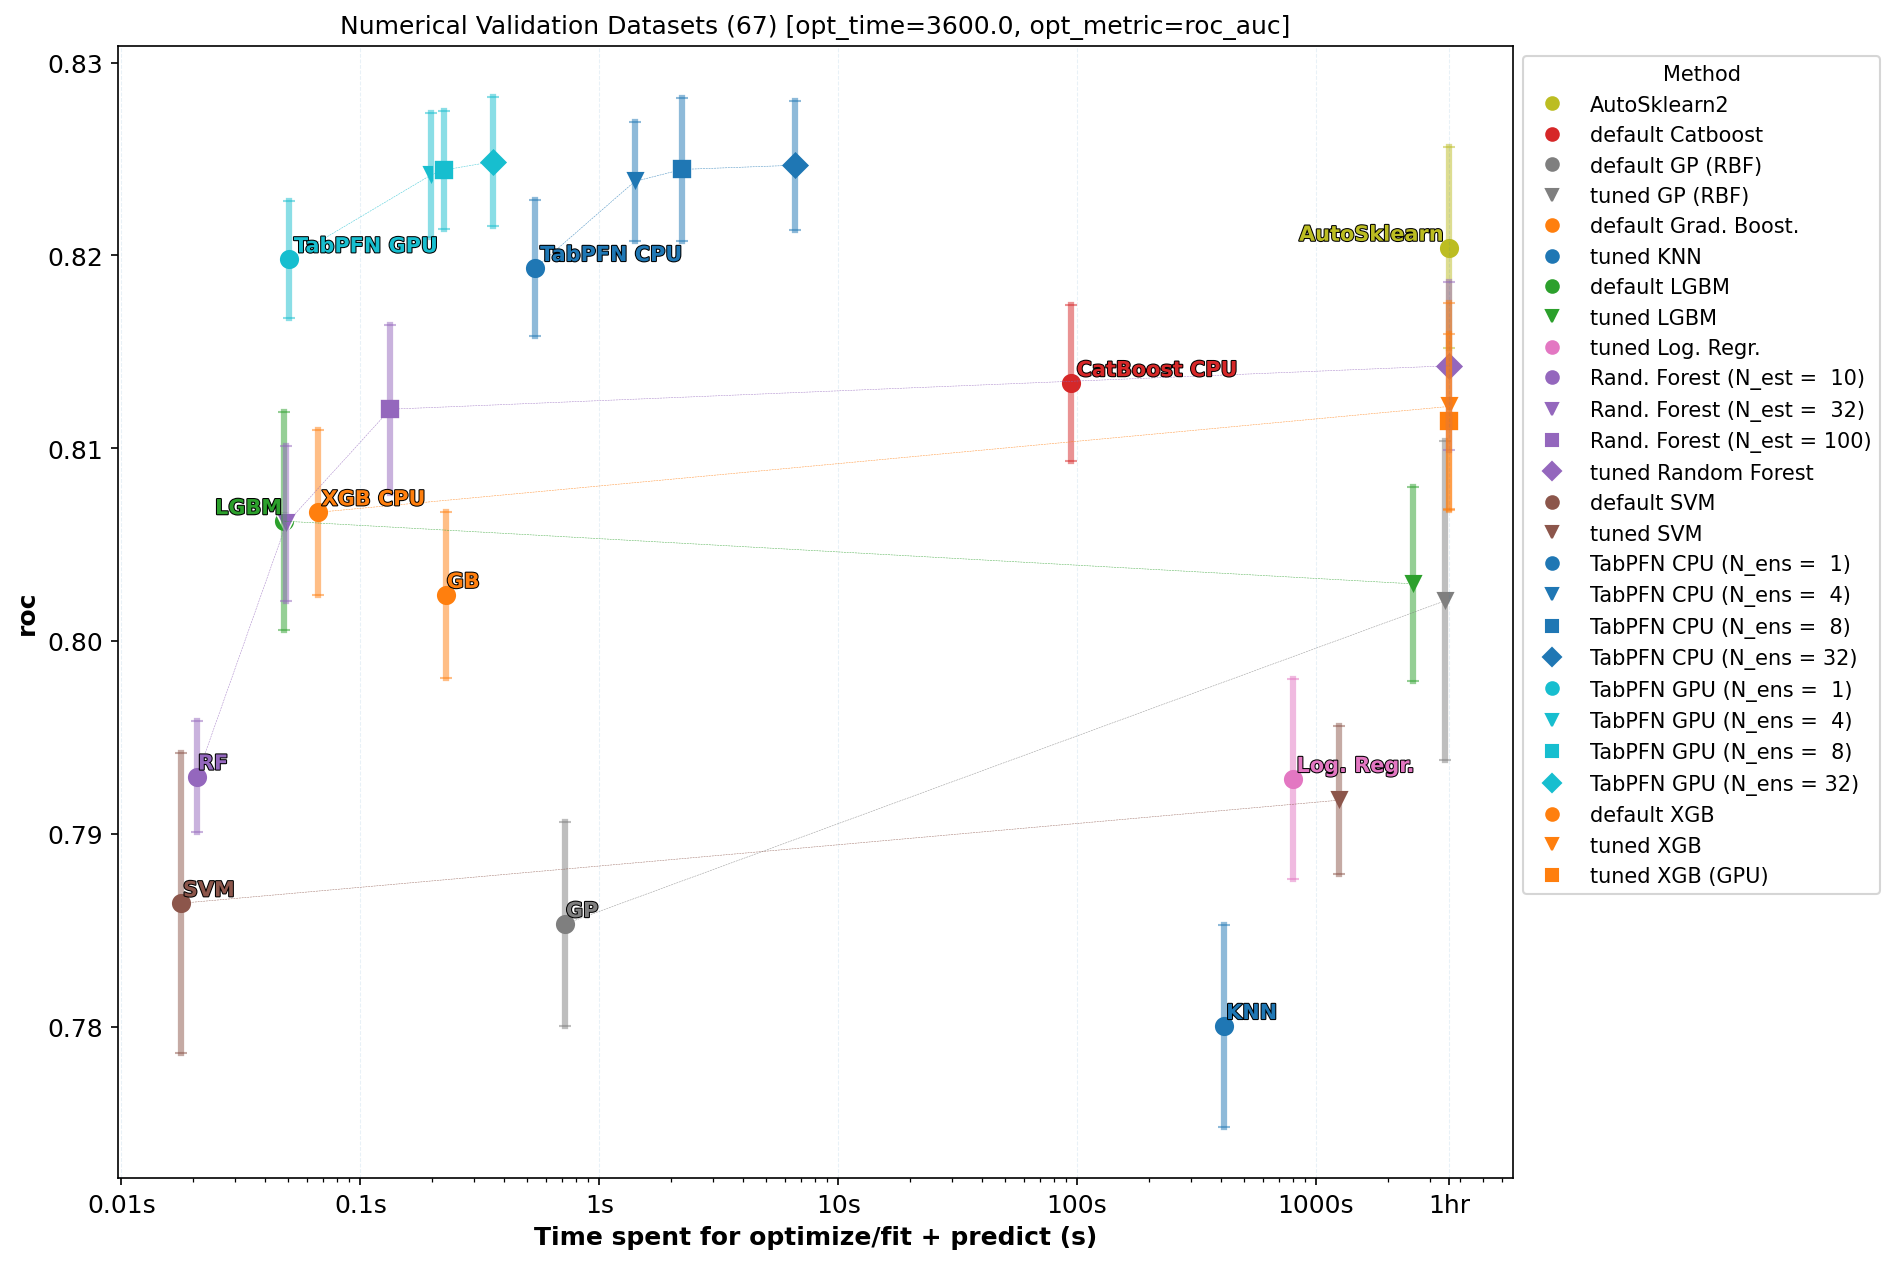

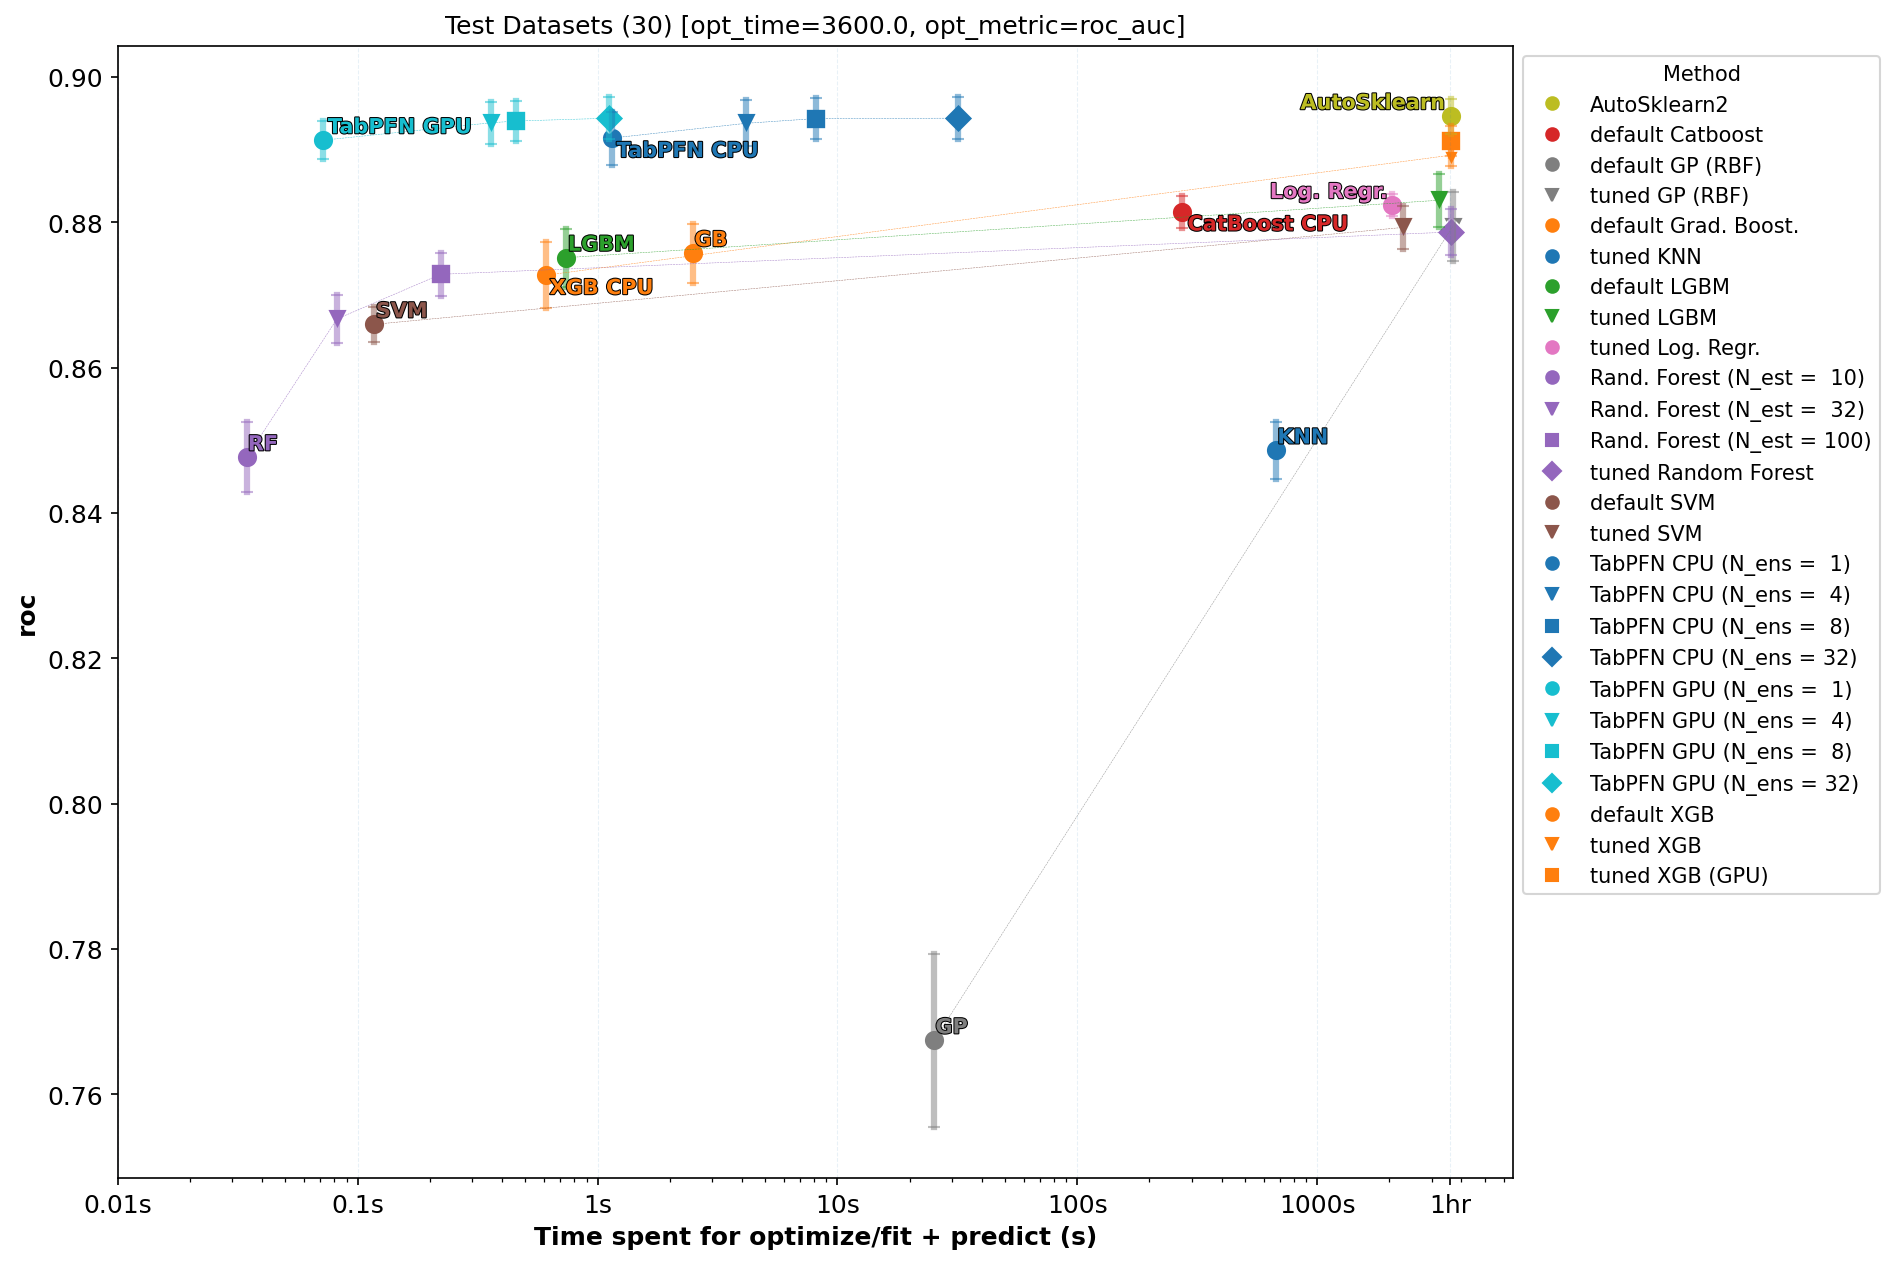

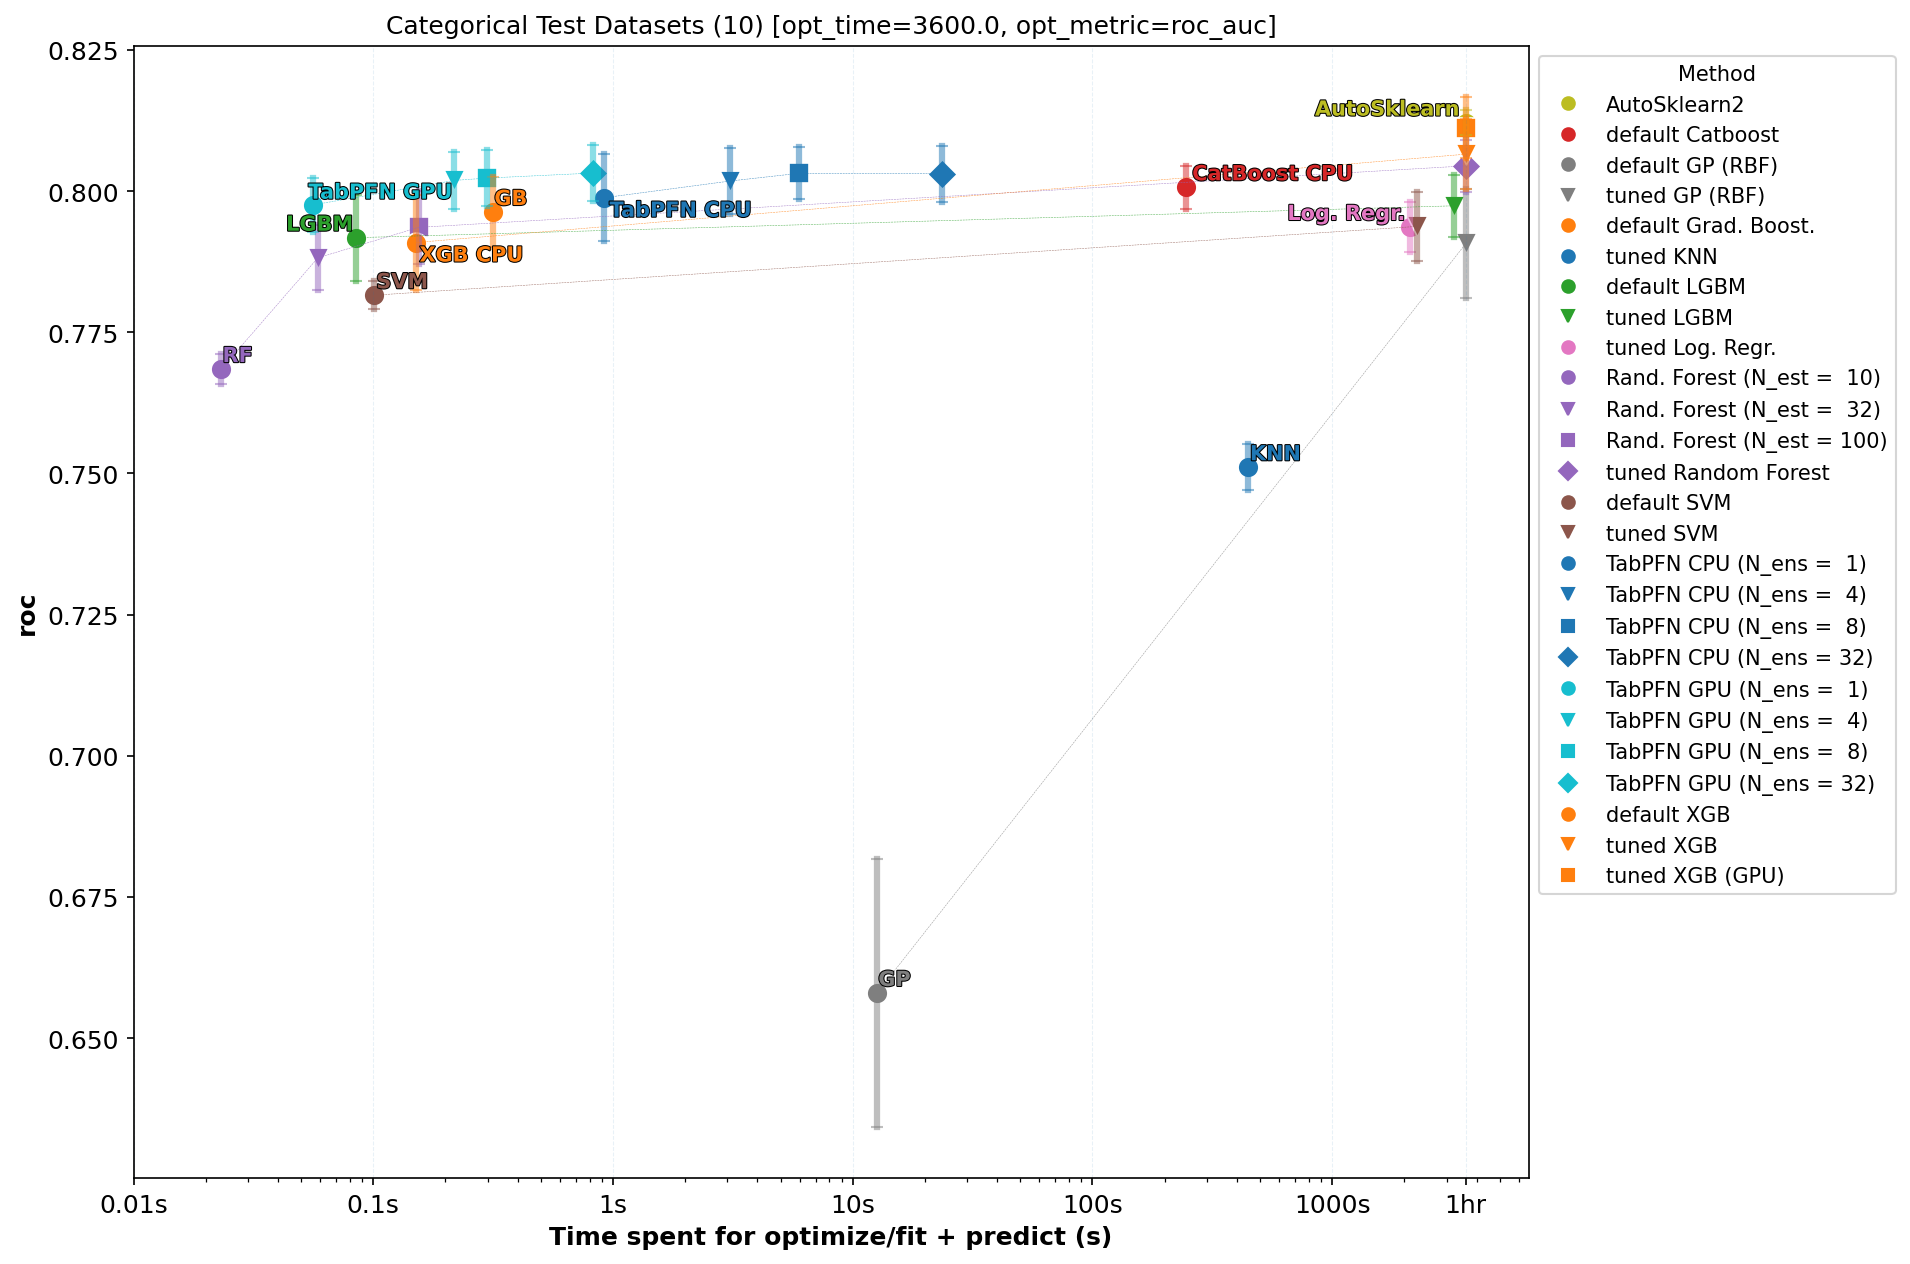

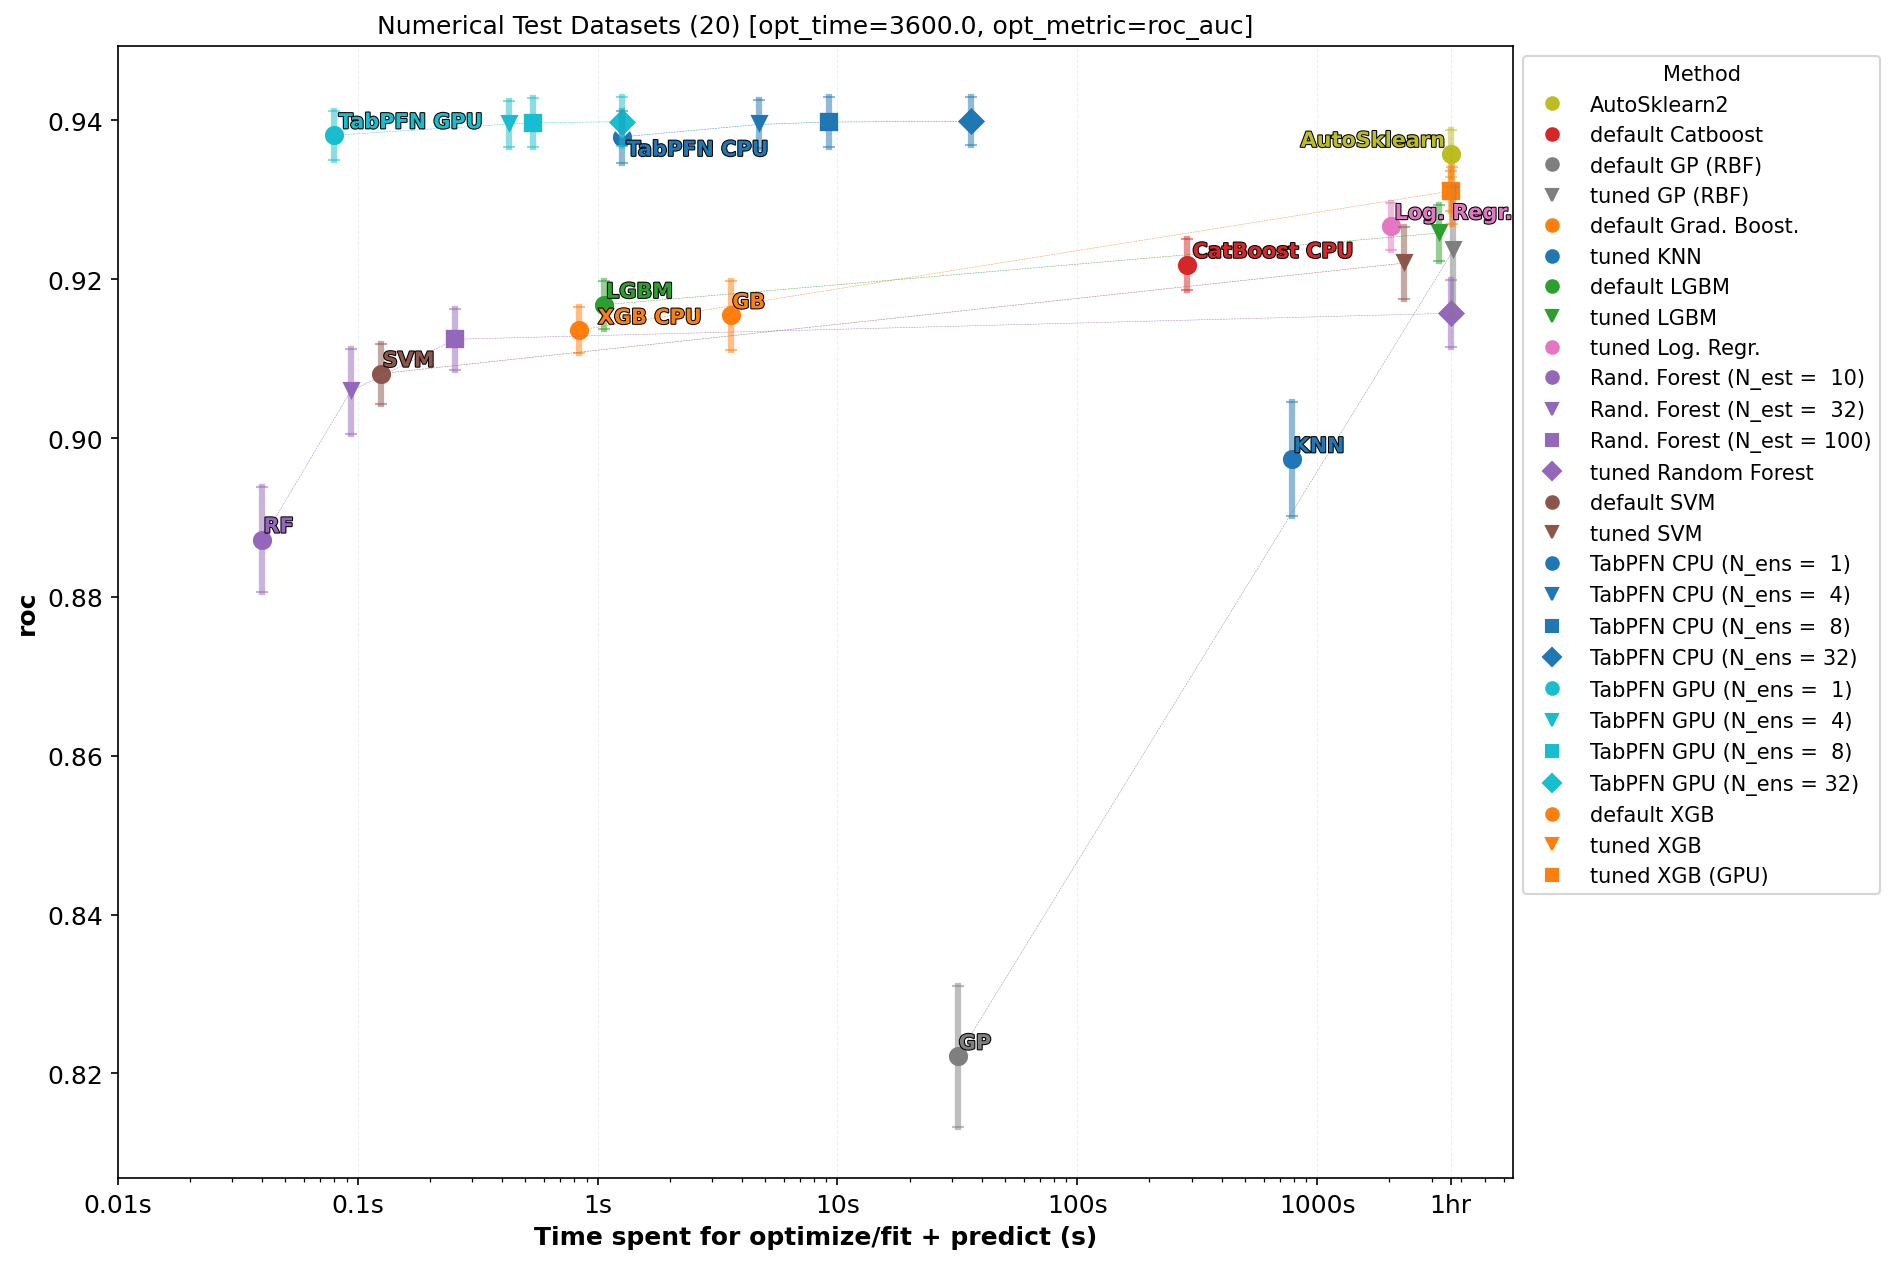

In [ ]:
from argparse import Namespace

# For your own custom evaluation, please comment out the one from below
args = Namespace(
    result_path=HERE, # Where to store results - HERE/results
    gpu=True,  # Whether a GPU is accessible
    times=[3600], # How much optimization time is given to methods requiring it
    splits=5, # How many splits to run
    validation_datasets=[13, 59, 4], # "cc_valid" or list of openml ids
    test_datasets=[973, 1596, 40981], # "cc_test" or list of openml ids
    optimization_metrics=["roc"], # ["roc", "cross_entropy", "acc", "brier_score", "ece"]m
    recorded_metrics=["roc", "cross_entropy", "acc", "brier_score", "ece"], # Same as above
    methods=["rf_default", "transformer_gpu_N_8"], # See keys of METHODS in Constants section
    fetch_only=True, # Will only fetch results and not compute anything
    bptt=2_000, # Transformer sequence length
    eval_positions=[1_000], # Leave as is
    overwrite=False, # Will overwrite results
    plot=True, # Do plots
    plot_directory=HERE/ "plots",  # Where to store plots
    figsize=(14, 10),  # The figure size for matplotlib
    dpi=140,  # The DPI for figures by matplotlib
    extension="pdf", # The extension for saving figures
    verbose=True,

    # Use this to use the predefined results from experiments
    # See the commented out block below
    load_predefined_results=False,
    predefined_results_path=PREDEFINED_RESULTS_PATH,
)

# This was used for generating the full overview plots,
# Comment out to use the above
args = Namespace(
    result_path=PREDEFINED_RESULTS_PATH,
    gpu=True,
    times=[3600.0],
    splits=5,
    validation_datasets="cc_valid",
    test_datasets="cc_test",
    optimization_metrics=["roc"],
    recorded_metrics=["roc", "cross_entropy", "acc", "brier_score", "ece"],
    methods=list(METHODS.keys()),
    fetch_only=True,
    bptt=2_000,
    eval_positions=[1_000],
    overwrite=False,

    plot=True,
    plot_directory=HERE/ "plots",
    figsize=(12, 10),
    dpi=150,
    extension="pdf",
    verbose=False,

    load_predefined_results=False,
    predefined_results_path=PREDEFINED_RESULTS_PATH,
)

# We need to create some directories for this to work
(args.result_path / "results" / "tabular" / "multiclass").mkdir(
    parents=True, exist_ok=True
)

# We ignore the flags datasets
filter_f = lambda d: d.name != "flags"  # noqa: ignore

valid_datasets = Dataset.fetch(args.validation_datasets, only=filter_f)
test_datasets = Dataset.fetch(args.test_datasets, only=filter_f)

all_datasets = valid_datasets + test_datasets

dataset_collections = {
    "All Datasets": [d.name for d in all_datasets],
    "Categorical Datasets": [d.name for d in all_datasets if d.categorical],
    "Numerical Datasets": [d.name for d in all_datasets if d.numerical],
    "Mixed Datasets": [d.name for d in all_datasets if d.mixed],
    #
    "Validation Datasets": [d.name for d in valid_datasets],
    "Categorical Validation Datasets": [
        d.name for d in valid_datasets if d.categorical or d.mixed
    ],
    "Numerical Validation Datasets": [
        d.name for d in valid_datasets if d.numerical
    ],
    #"Mixed Validation Datasets": [d.name for d in valid_datasets if d.mixed],
    #
    "Test Datasets": [d.name for d in test_datasets],
    "Categorical Test Datasets": [
        d.name for d in test_datasets if d.categorical or d.mixed
    ],
    "Numerical Test Datasets": [d.name for d in test_datasets if d.numerical],
    #"Mixed Test Datasets": [d.name for d in test_datasets if d.mixed],
}
blockPrint()
predefined_results_csv_path = args.predefined_results_path / "results" / "tabular" / "multiclass" / "predefined_results.csv"
if not args.load_predefined_results:
    result = do_evaluations(args, all_datasets)
else:
    headers = ["metric", "dataset"]
    indices = [
        "method",
        "optimization_metric",
        "optimization_time",
        "eval_position",
        "split",
    ]

    if predefined_results_csv_path.exists():
        df = pd.read_csv(
            predefined_results_csv_path,
            index_col=list(range(len(indices))),
            header=list(range(len(headers))),
        )
        result = Results(df)
    else:

        def read(_path: Path) -> dict:
            with _path.open("rb") as f:
                return pickle.load(f)

        d = {
            path.stem: read(path)
            for path in args.predefined_results_path.iterdir()
            if path.is_file()
        }
        result = Results.from_dict(
            d,
            datasets=all_datasets,
            recorded_metrics=args.recorded_metrics,
        )

        result.df.to_csv(predefined_results_csv_path, index=True)


if args.plot:
    args.plot_directory.mkdir(exist_ok=True, parents=True)

    for name, datasets in tqdm(dataset_collections.items(), "Dataset Collections"):
        do_plot(
            result=result.at(dataset=datasets),
            title_prefix=f"{name} ({len(datasets)})",
            fig_name=name.replace(" ", "_").lower(),
            path=args.plot_directory,
            figsize=tuple(args.figsize),  # type: ignore
            dpi=args.dpi,
            extension=args.extension,
        )
enablePrint()

In [ ]:
# Tables
collection = "Test Datasets"
test_results = result.at(
    dataset=dataset_collections[collection],
    optimization_time=3600,
    eval_position=1_000,
    optimization_metric="roc_auc",
)
df = test_results.df.T.groupby("metric").mean().T

# As string just to show all columns without truncation
print(df.groupby("method").agg(["mean", "std"]).sort_values(by=("roc", "mean"), ascending=False).T.to_string())